# **Assessment Task: Propensity Model for Anti-Money Laundering**
## Adam Fagan

In [ ]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
import keras

import warnings
warnings.filterwarnings('ignore')

Python and packages versions:

- python: 3.11.7
- pandas: 2.1.4
- numpy: 1.26.4
- seaborn: 0.12.2
- matplotlib: 3.8.0
- scikit-learn: 1.2.2
- keras: 3.7.0

## **Load the Data**

### **Load `csob_data_science_aml_part1.xlsx` file**

In [2]:
file_path_part1 = '/Users/adamfagan/Documents/csob_task/data/csob_data_science_aml_part1.xlsx'

sheets_part1 = pd.read_excel(file_path_part1, sheet_name=None)

Getting names of sheets

In [3]:
sheet_names_part1 = list(sheets_part1.keys()) 
print(', '.join(sheet_names_part1))

data_definition, data_kyc, data_kyt, data_suspicious_clients


Reading sheets into separate DataFrames

In [4]:
sheet1_name_part1, sheet2_name_part1, sheet3_name_part1, sheet4_name_part1 = sheet_names_part1

data_definition_part1 = pd.read_excel(file_path_part1, sheet_name=sheet1_name_part1)
data_kyc_part1 = pd.read_excel(file_path_part1, sheet_name=sheet2_name_part1)
data_kyt_part1 = pd.read_excel(file_path_part1, sheet_name=sheet3_name_part1)
data_suspicious_clients_part1 = pd.read_excel(file_path_part1, sheet_name=sheet4_name_part1)

Visual inspection of sheets

In [5]:
data_definition_part1

,Field,Definition
0,client_id,Unique identifier for each client.
1,incoming_transactions_num,Number of incoming transactions.
2,outgoing_transactions_num,Number of outgoing transactions.
3,incoming_transactions_vol,Total volume of incoming transactions.
4,outgoing_transactions_vol,Total volume of outgoing transactions.
5,incoming_cash_transactions_num,Number of incoming cash transactions.
6,outgoing_cash_transactions_num,Number of outgoing cash transactions.
7,incoming_cash_transactions_vol,Total volume of incoming cash transactions.
8,outgoing_cash_transactions_vol,Total volume of outgoing cash transactions.
9,incoming_wire_transactions_num,Number of incoming wire transactions.


In [6]:
data_kyc_part1

,client_id,client_age,account_age,client_income,nationality,gender,rs
0,46153,79,52,64873,Slovak,Male,0.054767
1,78769,24,63,35092,Czech,Male,0.109909
2,15408,78,82,111557,Czech,Female,0.121184
3,44521,23,90,34226,Czech,Male,0.244126
4,96176,30,21,28229,Non_EU_7,Female,0.257097
...,...,...,...,...,...,...,...
49995,26303,60,108,35572,Czech,Female,0.369559
49996,49550,25,67,29568,Czech,Female,0.980840
49997,9084,40,30,120452,Czech,Male,0.889471
49998,73666,59,25,41818,Czech,Female,0.455292


In [7]:
pd.set_option('display.max_columns', None)
data_kyt_part1

,client_id,incoming_transactions_num,outgoing_transactions_num,incoming_transactions_vol,outgoing_transactions_vol,incoming_cash_transactions_num,outgoing_cash_transactions_num,incoming_cash_transactions_vol,outgoing_cash_transactions_vol,incoming_wire_transactions_num,outgoing_wire_transactions_num,incoming_wire_transactions_vol,outgoing_wire_transactions_vol,incoming_international_transactions_num,outgoing_international_transactions_num,incoming_international_transactions_vol,outgoing_international_transactions_vol,incoming_international_risk_transactions_num,outgoing_international_risk_transactions_num,incoming_international_risk_transactions_vol,outgoing_international_risk_transactions_vol
0,46153,26.0,16.0,1626,4706,53,5,18936,12719,7,60,10822,52199,8,7,12370,11481,34,9,145,2788
1,78769,8.0,29.0,5635,2224,3,22,8662,4078,46,7,9731,21259,14,29,12228,633,5,6,1669,11000
2,15408,8.0,35.0,3639,7196,3,14,3503,10282,17,0,38050,367,17,17,8069,859,8,22,1374,1835
3,44521,17.0,1.0,7070,1456,49,5,25758,13644,12,26,52982,14051,12,15,10487,21310,6,16,11397,815
4,96176,32.0,36.0,779,33815,80,4,2278,5612,3,42,6431,14711,34,6,7043,8714,8,26,10722,4687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,26303,37.0,4.0,17454,19568,67,6,589,15324,1,9,2779,24338,13,1,7915,2865,27,20,23047,4917
49996,49550,42.0,9.0,2239,1106,6,14,13542,6083,20,18,18779,2655,26,9,9087,12020,6,12,4167,4722
49997,9084,57.0,22.0,31077,12875,19,8,3107,16819,13,12,21652,4441,9,4,2221,10019,3,12,9729,504
49998,73666,28.0,9.0,3650,2958,7,108,389,10146,9,9,8725,34742,12,12,20147,369,14,10,2154,3042


In [8]:
data_suspicious_clients_part1

,client_id
0,70099
1,50315
2,14179
3,26947
4,37637
...,...
968,91117
969,75910
970,739
971,13254


Since the data is divided into two sheets (datasets) in **part1** file (into four in overall), I prefered to perform a quick initial exploration of each dataset in **part1**, that contains necessary training and testing data, to ensure they are compatible for joining (merging). This helped me understand the structure of the data and identify any potential issues early on.

In [9]:
data_kyc_part1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   client_id      50000 non-null  int64  
 1   client_age     50000 non-null  int64  
 2   account_age    50000 non-null  int64  
 3   client_income  50000 non-null  int64  
 4   nationality    50000 non-null  object 
 5   gender         50000 non-null  object 
 6   rs             50000 non-null  float64
dtypes: float64(1), int64(4), object(2)
memory usage: 2.7+ MB


No missing values, 5 columns with numerical values, 2 columns with categorical values.

In [10]:
data_kyt_part1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   client_id                                     50000 non-null  int64  
 1   incoming_transactions_num                     49995 non-null  float64
 2   outgoing_transactions_num                     49995 non-null  float64
 3   incoming_transactions_vol                     50000 non-null  int64  
 4   outgoing_transactions_vol                     50000 non-null  int64  
 5   incoming_cash_transactions_num                50000 non-null  int64  
 6   outgoing_cash_transactions_num                50000 non-null  int64  
 7   incoming_cash_transactions_vol                50000 non-null  int64  
 8   outgoing_cash_transactions_vol                50000 non-null  int64  
 9   incoming_wire_transactions_num                50000 non-null 

There are 5 missing values in the `incoming_transactions_num` and `outgoing_transactions_num` columns.

21 columns with numerical values, no columns with categorical values.

Identifying rows with missing values in the columns with missing values. I will process these rows after merging all parts of the dataset.

In [11]:
missing_rows_part1 = data_kyt_part1[data_kyt_part1['incoming_transactions_num'].isnull() | data_kyt_part1['outgoing_transactions_num'].isnull()]
print('Rows with missing values in data_kyt_part1:')
missing_rows_part1

Rows with missing values in data_kyt_part1:


,client_id,incoming_transactions_num,outgoing_transactions_num,incoming_transactions_vol,outgoing_transactions_vol,incoming_cash_transactions_num,outgoing_cash_transactions_num,incoming_cash_transactions_vol,outgoing_cash_transactions_vol,incoming_wire_transactions_num,outgoing_wire_transactions_num,incoming_wire_transactions_vol,outgoing_wire_transactions_vol,incoming_international_transactions_num,outgoing_international_transactions_num,incoming_international_transactions_vol,outgoing_international_transactions_vol,incoming_international_risk_transactions_num,outgoing_international_risk_transactions_num,incoming_international_risk_transactions_vol,outgoing_international_risk_transactions_vol
1562,50405,17.0,NaN,1391,10118,3,37,4364,1359,26,24,55959,28446,2,28,22050,437,25,7,1612,59
3108,27497,61.0,NaN,5879,10578,5,30,4454,22880,9,35,28173,29555,7,2,21308,9859,15,8,1377,12365
7262,11668,NaN,12.0,1718,6320,9,3,2532,1254,3,20,1409,51107,52,13,6723,11403,3,6,115,7957
11566,6976,13.0,NaN,11590,2081,6,8,962,8591,11,27,2369,42510,6,5,373,6093,16,2,12814,4159
11879,50298,2.0,NaN,11663,24027,8,20,993,15640,3,35,4538,62654,18,7,24493,3353,8,59,154,776
14005,74784,NaN,11.0,9724,2300,5,5,1414,20911,21,169,12412,45430,22,15,8524,622,31,12,1373,29168
30419,4778,NaN,8.0,19164,343,1,48,11931,837,11,37,34764,44450,16,3,6247,25553,10,3,13300,6293
30468,78532,13.0,NaN,3693,22999,11,18,13822,2033,15,16,30132,6768,22,8,15636,4517,23,5,1910,92
32316,33466,NaN,9.0,31045,17278,16,4,946,715,10,9,357,59036,6,9,5643,3106,7,29,2157,4280
46605,26212,NaN,7.0,14059,1559,10,19,1853,11340,29,10,9775,38029,10,36,3808,627,41,13,1756,1173


Check for duplicates in the key column `client_id`

This ensures no duplicate IDs could cause problems during the merge.

In [12]:
if data_kyc_part1['client_id'].duplicated().any():
    print('Duplicate client_id(s) found in data_kyc_part1')
else:
    print('No duplicate client_id(s) in data_kyc_part1')

if data_kyt_part1['client_id'].duplicated().any():
    print('Duplicate client_id(s) found in data_kyt_part1')
else:
    print('No duplicate client_id(s) in data_kyt_part1')

No duplicate client_id(s) in data_kyc_part1
No duplicate client_id(s) in data_kyt_part1


Check for mismatches in `client_id` between the two datasets

I do this to ensure I am not missing any clients in either dataset.

In [13]:
kyc_ids_part1 = set(data_kyc_part1['client_id'])
kyt_ids_part1 = set(data_kyt_part1['client_id'])

missing_in_kyc_part1 = kyt_ids_part1 - kyc_ids_part1
missing_in_kyt_part1 = kyc_ids_part1 - kyt_ids_part1

if missing_in_kyc_part1:
    print(f'client_id(s) in data_kyt_part1 but not in data_kyc_part1: {missing_in_kyc_part1}')
else:
    print('No missing client_id(s) in data_kyc_part1')

if missing_in_kyt_part1:
    print(f'client_id(s) in data_kyc_part1 but not in data_kyt_part1: {missing_in_kyt_part1}')
else:
    print('No missing client_id(s) in data_kyt_part1')

No missing client_id(s) in data_kyc_part1
No missing client_id(s) in data_kyt_part1


Perform the Join

Since there are no duplicate or missing `client_id` values, the join will proceed without issues, such as mismatched or lost data, or row duplication. Both datasets are interconnected and share `client_id` as the key column, so I perform an inner join to merge the datasets, ensuring a combination of the data based on the shared `client_id` values. I could technically chose a left join, right join, or outer join, the result would not differ in this specific scenario.

In [14]:
merged_data_part1 = pd.merge(data_kyc_part1, data_kyt_part1, on='client_id', how='inner')

Visual inspection of the merged data from **part1**

In [15]:
merged_data_part1

,client_id,client_age,account_age,client_income,nationality,gender,rs,incoming_transactions_num,outgoing_transactions_num,incoming_transactions_vol,outgoing_transactions_vol,incoming_cash_transactions_num,outgoing_cash_transactions_num,incoming_cash_transactions_vol,outgoing_cash_transactions_vol,incoming_wire_transactions_num,outgoing_wire_transactions_num,incoming_wire_transactions_vol,outgoing_wire_transactions_vol,incoming_international_transactions_num,outgoing_international_transactions_num,incoming_international_transactions_vol,outgoing_international_transactions_vol,incoming_international_risk_transactions_num,outgoing_international_risk_transactions_num,incoming_international_risk_transactions_vol,outgoing_international_risk_transactions_vol
0,46153,79,52,64873,Slovak,Male,0.054767,26.0,16.0,1626,4706,53,5,18936,12719,7,60,10822,52199,8,7,12370,11481,34,9,145,2788
1,78769,24,63,35092,Czech,Male,0.109909,8.0,29.0,5635,2224,3,22,8662,4078,46,7,9731,21259,14,29,12228,633,5,6,1669,11000
2,15408,78,82,111557,Czech,Female,0.121184,8.0,35.0,3639,7196,3,14,3503,10282,17,0,38050,367,17,17,8069,859,8,22,1374,1835
3,44521,23,90,34226,Czech,Male,0.244126,17.0,1.0,7070,1456,49,5,25758,13644,12,26,52982,14051,12,15,10487,21310,6,16,11397,815
4,96176,30,21,28229,Non_EU_7,Female,0.257097,32.0,36.0,779,33815,80,4,2278,5612,3,42,6431,14711,34,6,7043,8714,8,26,10722,4687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,26303,60,108,35572,Czech,Female,0.369559,37.0,4.0,17454,19568,67,6,589,15324,1,9,2779,24338,13,1,7915,2865,27,20,23047,4917
49996,49550,25,67,29568,Czech,Female,0.980840,42.0,9.0,2239,1106,6,14,13542,6083,20,18,18779,2655,26,9,9087,12020,6,12,4167,4722
49997,9084,40,30,120452,Czech,Male,0.889471,57.0,22.0,31077,12875,19,8,3107,16819,13,12,21652,4441,9,4,2221,10019,3,12,9729,504
49998,73666,59,25,41818,Czech,Female,0.455292,28.0,9.0,3650,2958,7,108,389,10146,9,9,8725,34742,12,12,20147,369,14,10,2154,3042


In [16]:
merged_data_part1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   client_id                                     50000 non-null  int64  
 1   client_age                                    50000 non-null  int64  
 2   account_age                                   50000 non-null  int64  
 3   client_income                                 50000 non-null  int64  
 4   nationality                                   50000 non-null  object 
 5   gender                                        50000 non-null  object 
 6   rs                                            50000 non-null  float64
 7   incoming_transactions_num                     49995 non-null  float64
 8   outgoing_transactions_num                     49995 non-null  float64
 9   incoming_transactions_vol                     50000 non-null 

As expected, the join proceeded without issues and the merged data from **part1** has 27 columns. I will process rows with missing values after merging all parts of the dataset (still missing data from **part2**)

---------------------

The same process with **part2**

### **Load `csob_data_science_aml_part2.xlsx` file**

In [17]:
file_path_part2 = '/Users/adamfagan/Documents/csob_task/data/csob_data_science_aml_part2.xlsx'

sheets_part2 = pd.read_excel(file_path_part2, sheet_name=None)

Getting names of sheets

In [18]:
sheet_names_part2 = list(sheets_part2.keys()) 
print(', '.join(sheet_names_part2))

data_kyc, data_kyt


Reading sheets into separate DataFrames

In [19]:
sheet1_name_part2, sheet2_name_part2 = sheet_names_part2

data_kyc_part2 = pd.read_excel(file_path_part2, sheet_name=sheet1_name_part2)
data_kyt_part2 = pd.read_excel(file_path_part2, sheet_name=sheet2_name_part2)

Visual inspection of sheets

In [20]:
data_kyc_part2

,client_id,client_age,account_age,client_income,nationality,gender,rs
0,29431,20,83,14017,Czech,Male,0.143030
1,54809,27,90,50382,Czech,Female,0.758285
2,28263,72,43,86444,Czech,Female,0.834338
3,26167,34,64,71557,Czech,Female,0.714165
4,49546,65,14,85610,EU_7,Male,0.167502
...,...,...,...,...,...,...,...
49995,4636,46,104,10521,Czech,Female,0.417748
49996,15954,69,116,62383,Czech,Male,0.565244
49997,1709,37,108,32813,Czech,Female,0.616270
49998,89085,58,89,117888,Czech,Female,0.914122


In [21]:
data_kyt_part2

,client_id,incoming_transactions_num,outgoing_transactions_num,incoming_transactions_vol,outgoing_transactions_vol,incoming_cash_transactions_num,outgoing_cash_transactions_num,incoming_cash_transactions_vol,outgoing_cash_transactions_vol,incoming_wire_transactions_num,outgoing_wire_transactions_num,incoming_wire_transactions_vol,outgoing_wire_transactions_vol,incoming_international_transactions_num,outgoing_international_transactions_num,incoming_international_transactions_vol,outgoing_international_transactions_vol,incoming_international_risk_transactions_num,outgoing_international_risk_transactions_num,incoming_international_risk_transactions_vol,outgoing_international_risk_transactions_vol
0,29431,25.0,15.0,2991,9273,19,3,3914,2263,12,21,14419,13980,3,57,6305,497,25,14,1235,3434
1,54809,4.0,8.0,22014,958,26,212,2369,7564,61,5,14154,30765,9,19,7009,21524,14,10,3184,315
2,28263,19.0,24.0,5714,10861,52,4,3816,3864,76,10,22008,13178,2,9,2240,11181,117,7,5666,7550
3,26167,3.0,55.0,16695,28319,8,1,10266,2434,7,6,4488,51779,23,35,18719,11542,12,7,5160,7813
4,49546,15.0,2.0,8424,6659,17,10,33,810,1,50,90708,31579,11,50,1252,2673,27,65,7532,8275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,4636,9.0,7.0,2878,6846,22,42,659,3572,11,8,4295,1808,1,6,20383,3937,33,16,2979,11343
49996,15954,1.0,18.0,27253,11036,15,31,91,17561,4,24,1642,19248,14,83,23971,1949,17,2,26716,51
49997,1709,21.0,36.0,514,14010,5,29,125,7042,5,13,31129,26838,9,8,817,3234,20,17,4692,1492
49998,89085,6.0,43.0,1249,12314,11,5,12643,4207,14,1,1653,1400,7,8,7680,1451,43,100,438,4742


Since the data is divided into two sheets (datasets) also in **part2** file (into four in overall), I prefered to perform a quick initial exploration of each dataset in **part2**, that contains necessary training and testing data, to ensure they are compatible for joining (merging). This helped me understand the structure of the data and identify any potential issues early on.

In [22]:
data_kyc_part2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   client_id      50000 non-null  int64  
 1   client_age     50000 non-null  int64  
 2   account_age    50000 non-null  int64  
 3   client_income  50000 non-null  int64  
 4   nationality    50000 non-null  object 
 5   gender         50000 non-null  object 
 6   rs             50000 non-null  float64
dtypes: float64(1), int64(4), object(2)
memory usage: 2.7+ MB


No missing values, 5 columns with numerical values, 2 columns with categorical values.

In [23]:
data_kyt_part2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   client_id                                     50000 non-null  int64  
 1   incoming_transactions_num                     49995 non-null  float64
 2   outgoing_transactions_num                     49995 non-null  float64
 3   incoming_transactions_vol                     50000 non-null  int64  
 4   outgoing_transactions_vol                     50000 non-null  int64  
 5   incoming_cash_transactions_num                50000 non-null  int64  
 6   outgoing_cash_transactions_num                50000 non-null  int64  
 7   incoming_cash_transactions_vol                50000 non-null  int64  
 8   outgoing_cash_transactions_vol                50000 non-null  int64  
 9   incoming_wire_transactions_num                50000 non-null 

There are 5 missing values in the `incoming_transactions_num` and `outgoing_transactions_num` columns.

21 columns with numerical values, no columns with categorical values.

Identifying rows with missing values in the columns with missing values. I will process these rows after merging all parts of the dataset.

In [24]:
missing_rows_part2 = data_kyt_part2[data_kyt_part2['incoming_transactions_num'].isnull() | data_kyt_part2['outgoing_transactions_num'].isnull()]
print('Rows with missing values in data_kyt_part2:')
missing_rows_part2

Rows with missing values in data_kyt_part2:


,client_id,incoming_transactions_num,outgoing_transactions_num,incoming_transactions_vol,outgoing_transactions_vol,incoming_cash_transactions_num,outgoing_cash_transactions_num,incoming_cash_transactions_vol,outgoing_cash_transactions_vol,incoming_wire_transactions_num,outgoing_wire_transactions_num,incoming_wire_transactions_vol,outgoing_wire_transactions_vol,incoming_international_transactions_num,outgoing_international_transactions_num,incoming_international_transactions_vol,outgoing_international_transactions_vol,incoming_international_risk_transactions_num,outgoing_international_risk_transactions_num,incoming_international_risk_transactions_vol,outgoing_international_risk_transactions_vol
3039,36086,84.0,NaN,2548,3648,11,20,62,4487,85,99,30405,40637,5,3,6402,37772,31,4,5302,2051
4393,24648,NaN,2.0,17860,14225,6,152,2331,6524,17,9,1341,32967,13,39,287,4692,10,9,5500,1416
16760,61389,NaN,8.0,15802,458,5,5,863,8327,18,7,25595,1298,3,6,9061,9226,18,15,16064,6533
18164,15697,40.0,NaN,15540,12233,3,16,7311,3574,4,49,28797,29858,45,11,2828,13062,7,22,1893,7245
22580,57993,NaN,12.0,1034,11779,29,8,9303,1018,19,42,23005,376,12,16,3520,13,289,74,8865,5986
29266,89510,5.0,NaN,16238,5187,14,21,17391,5298,89,36,32298,19486,23,7,7107,6738,15,10,5281,539
36777,24831,7.0,NaN,4485,16179,52,10,320,5878,22,2,21080,23156,34,4,5485,6294,3,14,3172,4851
37894,55501,NaN,4.0,1368,16156,7,51,2261,9852,35,17,14020,12003,10,18,4014,10627,46,45,6222,1666
43726,82558,NaN,54.0,6684,10031,10,5,16575,7191,38,12,43922,13112,9,30,18460,7050,0,19,358,1186
47374,56924,14.0,NaN,1317,268,43,8,852,4255,6,44,17684,14117,5,10,1245,9971,4,4,3022,2614


Check for duplicates in the key column `client_id`

This ensures no duplicate IDs could cause problems during the merge.

In [25]:
if data_kyc_part2['client_id'].duplicated().any():
    print('Duplicate client_id(s) found in data_kyc_part2')
else:
    print('No duplicate client_id(s) in data_kyc_part2')

if data_kyt_part2['client_id'].duplicated().any():
    print('Duplicate client_id(s) found in data_kyt_part2')
else:
    print('No duplicate client_id(s) in data_kyt_part2')

No duplicate client_id(s) in data_kyc_part2
No duplicate client_id(s) in data_kyt_part2


Check for mismatches in `client_id` between the two datasets

I do this to ensure I am not missing any clients in either dataset.

In [26]:
kyc_ids_part2 = set(data_kyc_part2['client_id'])
kyt_ids_part2 = set(data_kyt_part2['client_id'])

missing_in_kyc_part2 = kyt_ids_part2 - kyc_ids_part2
missing_in_kyt_part2 = kyc_ids_part2 - kyt_ids_part2

if missing_in_kyc_part2:
    print(f'client_id(s) in data_kyt_part2 but not in data_kyc_part2: {missing_in_kyc_part2}')
else:
    print('No missing client_id(s) in data_kyc_part2')

if missing_in_kyt_part2:
    print(f'client_id(s) in data_kyc_part2 but not in data_kyt_part2: {missing_in_kyt_part2}')
else:
    print('No missing client_id(s) in data_kyt_part2')

No missing client_id(s) in data_kyc_part2
No missing client_id(s) in data_kyt_part2


Perform the Join

Since there are no duplicate or missing `client_id` values, the join will proceed without issues, such as mismatched or lost data, or row duplication. Both datasets are interconnected and share `client_id` as the key column, so I perform an inner join to merge the datasets, ensuring a combination of the data based on the shared `client_id` values. I could technically chose a left join, right join, or outer join, the result would not differ in this specific scenario.

In [27]:
merged_data_part2 = pd.merge(data_kyc_part2, data_kyt_part2, on='client_id', how='inner')

Visual inspection of the merged data from **part2**

In [28]:
merged_data_part2

,client_id,client_age,account_age,client_income,nationality,gender,rs,incoming_transactions_num,outgoing_transactions_num,incoming_transactions_vol,outgoing_transactions_vol,incoming_cash_transactions_num,outgoing_cash_transactions_num,incoming_cash_transactions_vol,outgoing_cash_transactions_vol,incoming_wire_transactions_num,outgoing_wire_transactions_num,incoming_wire_transactions_vol,outgoing_wire_transactions_vol,incoming_international_transactions_num,outgoing_international_transactions_num,incoming_international_transactions_vol,outgoing_international_transactions_vol,incoming_international_risk_transactions_num,outgoing_international_risk_transactions_num,incoming_international_risk_transactions_vol,outgoing_international_risk_transactions_vol
0,29431,20,83,14017,Czech,Male,0.143030,25.0,15.0,2991,9273,19,3,3914,2263,12,21,14419,13980,3,57,6305,497,25,14,1235,3434
1,54809,27,90,50382,Czech,Female,0.758285,4.0,8.0,22014,958,26,212,2369,7564,61,5,14154,30765,9,19,7009,21524,14,10,3184,315
2,28263,72,43,86444,Czech,Female,0.834338,19.0,24.0,5714,10861,52,4,3816,3864,76,10,22008,13178,2,9,2240,11181,117,7,5666,7550
3,26167,34,64,71557,Czech,Female,0.714165,3.0,55.0,16695,28319,8,1,10266,2434,7,6,4488,51779,23,35,18719,11542,12,7,5160,7813
4,49546,65,14,85610,EU_7,Male,0.167502,15.0,2.0,8424,6659,17,10,33,810,1,50,90708,31579,11,50,1252,2673,27,65,7532,8275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,4636,46,104,10521,Czech,Female,0.417748,9.0,7.0,2878,6846,22,42,659,3572,11,8,4295,1808,1,6,20383,3937,33,16,2979,11343
49996,15954,69,116,62383,Czech,Male,0.565244,1.0,18.0,27253,11036,15,31,91,17561,4,24,1642,19248,14,83,23971,1949,17,2,26716,51
49997,1709,37,108,32813,Czech,Female,0.616270,21.0,36.0,514,14010,5,29,125,7042,5,13,31129,26838,9,8,817,3234,20,17,4692,1492
49998,89085,58,89,117888,Czech,Female,0.914122,6.0,43.0,1249,12314,11,5,12643,4207,14,1,1653,1400,7,8,7680,1451,43,100,438,4742


In [29]:
merged_data_part2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   client_id                                     50000 non-null  int64  
 1   client_age                                    50000 non-null  int64  
 2   account_age                                   50000 non-null  int64  
 3   client_income                                 50000 non-null  int64  
 4   nationality                                   50000 non-null  object 
 5   gender                                        50000 non-null  object 
 6   rs                                            50000 non-null  float64
 7   incoming_transactions_num                     49995 non-null  float64
 8   outgoing_transactions_num                     49995 non-null  float64
 9   incoming_transactions_vol                     50000 non-null 

As expected, the join proceeded without issues and the merged data from **part2** has 27 columns. I will process rows with missing values after concatenating both parts of the whole dataset - at this moment after merging these parts are **merged_data_part1** and **merged_data_part2**

----------------

### **Concatenating both parts: `merged_data_part1` and `merged_data_part2`**

Check if there are any common IDs in between both parts

In [30]:
merged_data_ids_part1 = set(merged_data_part1['client_id'])
merged_data_ids_part2 = set(merged_data_part2['client_id'])

common_ids = merged_data_ids_part1.intersection(merged_data_ids_part2)

if common_ids:
    print('Common client IDs found in both parts:')
    print(common_ids)
else:
    print('No common client IDs found between the parts.')


No common client IDs found between the parts.


There are not any common client IDs in between both parts, so there will be not duplicates after concatenating them.

Just a check to confirm visual inspection, that the columns are exactly identical in both parts.

In [31]:
if list(merged_data_part1.columns) == list(merged_data_part2.columns):
    print('The columns in both datasets are identical')
else:
    print('The columns in the datasets do not match')

The columns in both datasets are identical


Concatenating both parts into one coherent dataset.

In [32]:
full_dataset = pd.concat([merged_data_part1, merged_data_part2], ignore_index=True)

------------

## **Data Preprocessing and Exploratory Data Analysis**

Visual inspection of the concatenated dataset. The visual inspection helps me ensure that the concatenation worked correctly and the data looks as expected.

In [33]:
full_dataset

,client_id,client_age,account_age,client_income,nationality,gender,rs,incoming_transactions_num,outgoing_transactions_num,incoming_transactions_vol,outgoing_transactions_vol,incoming_cash_transactions_num,outgoing_cash_transactions_num,incoming_cash_transactions_vol,outgoing_cash_transactions_vol,incoming_wire_transactions_num,outgoing_wire_transactions_num,incoming_wire_transactions_vol,outgoing_wire_transactions_vol,incoming_international_transactions_num,outgoing_international_transactions_num,incoming_international_transactions_vol,outgoing_international_transactions_vol,incoming_international_risk_transactions_num,outgoing_international_risk_transactions_num,incoming_international_risk_transactions_vol,outgoing_international_risk_transactions_vol
0,46153,79,52,64873,Slovak,Male,0.054767,26.0,16.0,1626,4706,53,5,18936,12719,7,60,10822,52199,8,7,12370,11481,34,9,145,2788
1,78769,24,63,35092,Czech,Male,0.109909,8.0,29.0,5635,2224,3,22,8662,4078,46,7,9731,21259,14,29,12228,633,5,6,1669,11000
2,15408,78,82,111557,Czech,Female,0.121184,8.0,35.0,3639,7196,3,14,3503,10282,17,0,38050,367,17,17,8069,859,8,22,1374,1835
3,44521,23,90,34226,Czech,Male,0.244126,17.0,1.0,7070,1456,49,5,25758,13644,12,26,52982,14051,12,15,10487,21310,6,16,11397,815
4,96176,30,21,28229,Non_EU_7,Female,0.257097,32.0,36.0,779,33815,80,4,2278,5612,3,42,6431,14711,34,6,7043,8714,8,26,10722,4687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,4636,46,104,10521,Czech,Female,0.417748,9.0,7.0,2878,6846,22,42,659,3572,11,8,4295,1808,1,6,20383,3937,33,16,2979,11343
99996,15954,69,116,62383,Czech,Male,0.565244,1.0,18.0,27253,11036,15,31,91,17561,4,24,1642,19248,14,83,23971,1949,17,2,26716,51
99997,1709,37,108,32813,Czech,Female,0.616270,21.0,36.0,514,14010,5,29,125,7042,5,13,31129,26838,9,8,817,3234,20,17,4692,1492
99998,89085,58,89,117888,Czech,Female,0.914122,6.0,43.0,1249,12314,11,5,12643,4207,14,1,1653,1400,7,8,7680,1451,43,100,438,4742


As expected the concatenated dataset contains 100000 rows and 27 columns

After merging and concatenating the data, I begin by exploring it as a single dataset to identify issues such as missing values, erroneous entries, values in categorical columns, and other potential anomalies. Once the initial exploration is complete, I split the dataset into two subsets:

1. **Flagged Suspicious Clients** (`flagged_suspicious_clients_dataset`): This subset contains clients flagged as suspicious.  
2. **Non-Flagged Clients** (`non_flagged_clients_dataset`): This subset includes clients whose suspicious status is yet to be determined.

Next, I will compare the distributions, patterns, and general statistics of columns between these subsets. The goal is to identify features or trends that differentiate flagged suspicious clients from the rest of the dataset.


### **Initial exploration and preprocessing**

In [34]:
full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 27 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   client_id                                     100000 non-null  int64  
 1   client_age                                    100000 non-null  int64  
 2   account_age                                   100000 non-null  int64  
 3   client_income                                 100000 non-null  int64  
 4   nationality                                   100000 non-null  object 
 5   gender                                        100000 non-null  object 
 6   rs                                            100000 non-null  float64
 7   incoming_transactions_num                     99990 non-null   float64
 8   outgoing_transactions_num                     99990 non-null   float64
 9   incoming_transactions_vol                     100

As expected there are 10 missing values in the `incoming_transactions_num` and `outgoing_transactions_num` columns.

25 columns with numerical values, 2 columns with categorical values.

In [35]:
full_dataset.describe()

,client_id,client_age,account_age,client_income,rs,incoming_transactions_num,outgoing_transactions_num,incoming_transactions_vol,outgoing_transactions_vol,incoming_cash_transactions_num,outgoing_cash_transactions_num,incoming_cash_transactions_vol,outgoing_cash_transactions_vol,incoming_wire_transactions_num,outgoing_wire_transactions_num,incoming_wire_transactions_vol,outgoing_wire_transactions_vol,incoming_international_transactions_num,outgoing_international_transactions_num,incoming_international_transactions_vol,outgoing_international_transactions_vol,incoming_international_risk_transactions_num,outgoing_international_risk_transactions_num,incoming_international_risk_transactions_vol,outgoing_international_risk_transactions_vol
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,99990.000000,99990.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,50000.500000,48.47384,60.032240,49943.327410,0.498717,19.664376,19.702490,9924.822340,10001.537410,20.175830,19.477530,5096.004270,4983.931610,19.485020,19.772450,20000.554070,19931.31074,19.538950,19.550350,10015.303680,10017.524720,19.559910,19.523110,5016.186630,5039.321480
std,28867.657797,17.89529,34.403313,49862.875965,0.288099,26.258472,27.232483,9923.958636,9980.301798,27.973562,25.886841,8691.215683,4991.713706,25.948268,26.428268,19943.157468,19993.27393,26.482181,25.780849,10131.056787,9973.800589,26.201601,25.993714,5007.081128,5030.192711
min,1.000000,18.00000,-1.000000,-48359.000000,0.000007,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.00000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25000.750000,33.00000,30.000000,14411.750000,0.248931,6.000000,6.000000,2841.000000,2889.000000,6.000000,6.000000,1443.750000,1426.000000,6.000000,6.000000,5799.750000,5705.00000,6.000000,6.000000,2892.000000,2866.000000,6.000000,6.000000,1460.000000,1453.000000
50%,50000.500000,49.00000,60.000000,34822.000000,0.496997,12.000000,12.000000,6872.000000,6936.000000,12.000000,12.000000,3476.000000,3459.000000,12.000000,12.000000,13881.000000,13803.00000,12.000000,12.000000,6895.000000,6964.000000,12.000000,12.000000,3488.000000,3498.000000
75%,75000.250000,64.00000,90.000000,69239.500000,0.748776,24.000000,23.000000,13772.250000,13881.250000,24.000000,23.000000,6967.000000,6917.000000,23.000000,24.000000,27767.000000,27518.00000,24.000000,23.000000,13809.250000,13948.250000,23.000000,23.000000,6954.250000,6971.000000
max,100000.000000,122.00000,119.000000,611589.000000,0.999999,891.000000,1146.000000,132777.000000,120154.000000,1131.000000,924.000000,1000000.000000,58359.000000,1242.000000,757.000000,255841.000000,250139.00000,1681.000000,721.000000,116445.000000,105318.000000,943.000000,752.000000,63076.000000,50879.000000


- **Anomalies**:
   - **Missing Data**:
      - As already said, `incoming_transactions_num` and `outgoing_transactions_num` have counts of `99990`, slightly less than the total of `100000`. This indicates missing data in these columns for 10 rows (20 in total). Rows with missing values might still contain other critical information and should be assessed carefully rather than removed outright.
   - **Negative Values**:
     - `account_age` has a minimum value of `-1.0`, which is not logical. This might indicate a data entry error or an encoding issue. The negative values should be corrected or excluded unless it reflects some edge-case behavior tied to flagged accounts.
     - Similarly, `client_income` has a minimum value of `-48359.0`, which is unrealistic. Negative incomes should be investigated but not outright removed, as they could represent unusual scenarios tied to flagged clients.
   - **High values**:
      - The `client_age` ranges from `18` to `122`. The upper end of this range seems unusually high, potentially indicating either:
         - Data errors.
         - Outliers representing centenarians or mistakenly entered values.

- **Categorical columns (`gender` and `nationality`)**:
   - These are categorical columns not visible in the summary but should be explored to determine the number of unique categories in each column and potentially preprocess them. If analysis reveals that these columns are likely to be helpful for modeling, they should be preprocessed, potentially using the one-hot encoding technique.

#### **Anomalies**

Missing values in `incoming_transactions_num` and `outgoing_transactions_num`.

Assuming these records were reviewed by the Compliance Department of the fictional bank, I will carefully examine them to ensure that no valuable data from flagged suspicious clients is mistakenly removed.

In [36]:
missing_transactions_ids = full_dataset[
    full_dataset['incoming_transactions_num'].isna() | full_dataset['outgoing_transactions_num'].isna()
]['client_id']

missing_transactions_suspicious = data_suspicious_clients_part1[
    data_suspicious_clients_part1['client_id'].isin(missing_transactions_ids)
]

print(f'Number of clients with missing transaction values: {len(missing_transactions_ids)}')
print(f'Number of suspicious clients with missing transaction values: {len(missing_transactions_suspicious)}')

Number of clients with missing transaction values: 20
Number of suspicious clients with missing transaction values: 0


Negative values in `account_age` column.

Check if any of the clients with negative value in `account_age` column are among the suspicious clients.

In [37]:
negative_account_age_ids = full_dataset[full_dataset['account_age'] < 0]['client_id']

negative_account_age_suspicious = data_suspicious_clients_part1[
    data_suspicious_clients_part1['client_id'].isin(negative_account_age_ids)
]

print(f'Number of clients with negative account age: {len(negative_account_age_ids)}')
print(f'Number of suspicious clients with negative account age: {len(negative_account_age_suspicious)}')

Number of clients with negative account age: 10
Number of suspicious clients with negative account age: 0


Negative values in `client_income` column.

Check if any of the clients with negative value in `client_income` column are among the suspicious clients.

In [38]:
negative_income_ids = full_dataset[full_dataset['client_income'] < 0]['client_id']

negative_income_suspicious = data_suspicious_clients_part1[
    data_suspicious_clients_part1['client_id'].isin(negative_income_ids)
]

print(f'Number of clients with negative client income: {len(negative_income_ids)}')
print(f'Number of suspicious clients with negative client income: {len(negative_income_suspicious)}')

Number of clients with negative client income: 2
Number of suspicious clients with negative client income: 0


High values in `client_age` column.

Check if any client is older than 116 years, as the current oldest living person is 116 years old. Any client aged above 116 would be considered an error. And check if any of the clients older than 116 years are among the suspicious clients.

In [39]:
client_age_above_116_ids = full_dataset[full_dataset['client_age'] > 116]['client_id']

client_age_above_116_suspicious = data_suspicious_clients_part1[
    data_suspicious_clients_part1['client_id'].isin(client_age_above_116_ids)
]

print(f'Number of clients above age 116: {len(client_age_above_116_ids)}')
print(f'Number of suspicious clients above age 116: {len(client_age_above_116_suspicious)}')

Number of clients above age 116: 3
Number of suspicious clients above age 116: 0


Upon reviewing the dataset, anomalies such as missing values in transaction counts, negative values in `account_age`, negative `client_income`, and `client_age` above 116 appear to be errors rather than meaningful data. Since these records are relatively few in number and do not overlap with flagged suspicious clients, I have decided to remove them. This ensures the integrity of the dataset while minimizing the impact on the analysis and modeling process.

In [40]:
ids_to_remove = set(missing_transactions_ids) | set(negative_account_age_ids) | set(negative_income_ids) | set(client_age_above_116_ids)
cleaned_dataset = full_dataset[~full_dataset['client_id'].isin(ids_to_remove)]

print(f'Original dataset size: {len(full_dataset)}')
print(f'Cleaned dataset size: {len(cleaned_dataset)}')
print(f'Number of removed records: {len(ids_to_remove)}')

Original dataset size: 100000
Cleaned dataset size: 99965
Number of removed records: 35


#### **Categorical columns (`gender` and `nationality`)**

Exploring unique categories in these two categorical columns

In [41]:
gender_categories = cleaned_dataset['gender'].value_counts()
nationality_categories = cleaned_dataset['nationality'].value_counts()

print(f'Gender categories:\n{gender_categories}')
print(f'\n\nNationality categories:\n{nationality_categories}')

Gender categories:
gender
Male      50161
Female    49804
Name: count, dtype: int64


Nationality categories:
nationality
Czech        85014
Slovak        5117
EU_14          361
EU_3           360
EU_10          356
Non_EU_11      354
EU_7           347
EU_6           346
EU_13          345
EU_5           339
EU_11          335
Non_EU_10      335
EU_12          335
Non_EU_6       333
Non_EU_12      331
Non_EU_2       331
Non_EU_4       330
Non_EU_13      326
Non_EU_1       325
EU_15          320
Non_EU_14      320
EU_1           320
EU_9           319
Non_EU_5       318
Non_EU_9       318
EU_4           316
Non_EU_15      315
Non_EU_8       314
Non_EU_3       305
EU_8           305
Non_EU_7       291
EU_2           284
Name: count, dtype: int64


Nationality has a large number of unique categories, which can lead to a high cardinality feature when used directly in a machine learning model. This can be problematic in some models, especially if the dataset is not large enough, as it may lead to overfitting or sparse representations.

By grouping nationalities into broader categories, I reduce the number of unique values and make the feature more manageable and meaningful, potentially improving the model's ability to generalize.

Also certain nationalities have very few observations in the dataset, they might not provide enough information to train the model effectively. Grouping these into a broader category ensures that even rare nationalities contribute meaningfully.

Creating a new column to classify nationalities into broader categories

In [44]:
processed_dataset = cleaned_dataset.copy()

processed_dataset['nationality_group'] = processed_dataset['nationality'].apply(
    lambda x: 'EU' if x.startswith('EU') else ('Non_EU' if x.startswith('Non_EU') else x)
)

processed_dataset = processed_dataset.drop(columns=['nationality'])

print(f"Nationality group categories:\n{processed_dataset['nationality_group'].value_counts()}")

Nationality group categories:
nationality_group
Czech     85014
Slovak     5117
EU         4988
Non_EU     4846
Name: count, dtype: int64


In [45]:
processed_dataset

,client_id,client_age,account_age,client_income,gender,rs,incoming_transactions_num,outgoing_transactions_num,incoming_transactions_vol,outgoing_transactions_vol,incoming_cash_transactions_num,outgoing_cash_transactions_num,incoming_cash_transactions_vol,outgoing_cash_transactions_vol,incoming_wire_transactions_num,outgoing_wire_transactions_num,incoming_wire_transactions_vol,outgoing_wire_transactions_vol,incoming_international_transactions_num,outgoing_international_transactions_num,incoming_international_transactions_vol,outgoing_international_transactions_vol,incoming_international_risk_transactions_num,outgoing_international_risk_transactions_num,incoming_international_risk_transactions_vol,outgoing_international_risk_transactions_vol,nationality_group
0,46153,79,52,64873,Male,0.054767,26.0,16.0,1626,4706,53,5,18936,12719,7,60,10822,52199,8,7,12370,11481,34,9,145,2788,Slovak
1,78769,24,63,35092,Male,0.109909,8.0,29.0,5635,2224,3,22,8662,4078,46,7,9731,21259,14,29,12228,633,5,6,1669,11000,Czech
2,15408,78,82,111557,Female,0.121184,8.0,35.0,3639,7196,3,14,3503,10282,17,0,38050,367,17,17,8069,859,8,22,1374,1835,Czech
3,44521,23,90,34226,Male,0.244126,17.0,1.0,7070,1456,49,5,25758,13644,12,26,52982,14051,12,15,10487,21310,6,16,11397,815,Czech
4,96176,30,21,28229,Female,0.257097,32.0,36.0,779,33815,80,4,2278,5612,3,42,6431,14711,34,6,7043,8714,8,26,10722,4687,Non_EU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,4636,46,104,10521,Female,0.417748,9.0,7.0,2878,6846,22,42,659,3572,11,8,4295,1808,1,6,20383,3937,33,16,2979,11343,Czech
99996,15954,69,116,62383,Male,0.565244,1.0,18.0,27253,11036,15,31,91,17561,4,24,1642,19248,14,83,23971,1949,17,2,26716,51,Czech
99997,1709,37,108,32813,Female,0.616270,21.0,36.0,514,14010,5,29,125,7042,5,13,31129,26838,9,8,817,3234,20,17,4692,1492,Czech
99998,89085,58,89,117888,Female,0.914122,6.0,43.0,1249,12314,11,5,12643,4207,14,1,1653,1400,7,8,7680,1451,43,100,438,4742,Czech


#### **Split the dataset into two subsets**

1. **Flagged Suspicious Clients** (`flagged_suspicious_clients_dataset`): This subset contains clients flagged as suspicious.  
2. **Non-Flagged Clients** (`non_flagged_clients_dataset`): This subset includes clients whose suspicious status is yet to be determined.

In [46]:
suspicious_client_ids = set(data_suspicious_clients_part1['client_id'])

flagged_suspicious_clients_dataset = processed_dataset[
    processed_dataset['client_id'].isin(suspicious_client_ids)
].copy()

non_flagged_clients_dataset = processed_dataset[
    ~processed_dataset['client_id'].isin(suspicious_client_ids)
].copy()

print(f'Number of flagged suspicious clients: {len(flagged_suspicious_clients_dataset)}')
print(f'Number of non-flagged clients: {len(non_flagged_clients_dataset)}')

Number of flagged suspicious clients: 973
Number of non-flagged clients: 98992


### **Summary statistics**

Defining numeric columns for future use

In [47]:
numeric_columns = [
    'client_age', 'account_age', 'client_income', 'rs', 
    'incoming_transactions_num', 'outgoing_transactions_num',
    'incoming_transactions_vol', 'outgoing_transactions_vol',
    'incoming_cash_transactions_num', 'outgoing_cash_transactions_num',
    'incoming_cash_transactions_vol', 'outgoing_cash_transactions_vol',
    'incoming_wire_transactions_num', 'outgoing_wire_transactions_num',
    'incoming_wire_transactions_vol', 'outgoing_wire_transactions_vol',
    'incoming_international_transactions_num', 'outgoing_international_transactions_num',
    'incoming_international_transactions_vol', 'outgoing_international_transactions_vol',
    'incoming_international_risk_transactions_num', 'outgoing_international_risk_transactions_num',
    'incoming_international_risk_transactions_vol', 'outgoing_international_risk_transactions_vol'
]

In [48]:
non_flagged_clients_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98992 entries, 0 to 99999
Data columns (total 27 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   client_id                                     98992 non-null  int64  
 1   client_age                                    98992 non-null  int64  
 2   account_age                                   98992 non-null  int64  
 3   client_income                                 98992 non-null  int64  
 4   gender                                        98992 non-null  object 
 5   rs                                            98992 non-null  float64
 6   incoming_transactions_num                     98992 non-null  float64
 7   outgoing_transactions_num                     98992 non-null  float64
 8   incoming_transactions_vol                     98992 non-null  int64  
 9   outgoing_transactions_vol                     98992 non-null  int6

In [49]:
non_flagged_clients_dataset.describe()

,client_id,client_age,account_age,client_income,rs,incoming_transactions_num,outgoing_transactions_num,incoming_transactions_vol,outgoing_transactions_vol,incoming_cash_transactions_num,outgoing_cash_transactions_num,incoming_cash_transactions_vol,outgoing_cash_transactions_vol,incoming_wire_transactions_num,outgoing_wire_transactions_num,incoming_wire_transactions_vol,outgoing_wire_transactions_vol,incoming_international_transactions_num,outgoing_international_transactions_num,incoming_international_transactions_vol,outgoing_international_transactions_vol,incoming_international_risk_transactions_num,outgoing_international_risk_transactions_num,incoming_international_risk_transactions_vol,outgoing_international_risk_transactions_vol
count,98992.000000,98992.000000,98992.000000,98992.000000,98992.000000,98992.000000,98992.000000,98992.000000,98992.000000,98992.000000,98992.000000,98992.000000,98992.000000,98992.000000,98992.000000,98992.000000,98992.000000,98992.000000,98992.000000,98992.000000,98992.000000,98992.000000,98992.000000,98992.000000,98992.000000
mean,50012.870586,48.482685,60.043559,49927.420519,0.497779,19.655417,19.804429,9923.682388,10003.025345,19.667519,19.477928,5059.631475,4982.336088,19.483696,19.771931,20001.602332,19992.380495,19.537579,19.547933,9925.634506,10017.551923,19.549236,19.502435,5015.908750,5018.097937
std,28864.358834,17.892932,34.397575,49856.510326,0.288445,26.217159,27.318902,9928.128586,9983.050982,25.792553,25.905239,8682.948134,4992.269358,25.970531,26.383145,19945.323889,20042.587642,26.472840,25.772953,9961.461094,9972.453761,26.156703,25.908422,5006.592884,4998.263121
min,1.000000,18.000000,1.000000,0.000000,0.000007,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25020.750000,33.000000,30.000000,14399.500000,0.247060,6.000000,6.000000,2840.000000,2888.000000,6.000000,6.000000,1438.000000,1424.000000,6.000000,6.000000,5796.750000,5722.000000,6.000000,6.000000,2876.000000,2865.000000,6.000000,6.000000,1460.750000,1448.000000
50%,50014.500000,49.000000,60.000000,34810.000000,0.495814,12.000000,12.000000,6869.000000,6938.500000,12.000000,12.000000,3462.000000,3457.000000,12.000000,12.000000,13890.500000,13857.000000,12.000000,12.000000,6850.000000,6964.000000,12.000000,12.000000,3488.000000,3487.000000
75%,75006.250000,64.000000,90.000000,69228.250000,0.748336,24.000000,23.000000,13765.250000,13885.250000,24.000000,23.000000,6926.250000,6915.000000,23.000000,24.000000,27754.250000,27612.250000,24.000000,23.000000,13702.000000,13954.000000,23.000000,23.000000,6953.000000,6947.250000
max,100000.000000,79.000000,119.000000,611589.000000,0.999999,891.000000,1146.000000,132777.000000,120154.000000,956.000000,924.000000,1000000.000000,58359.000000,1242.000000,757.000000,255841.000000,250139.000000,1681.000000,721.000000,115024.000000,105318.000000,943.000000,752.000000,63076.000000,50879.000000


In [50]:
non_flagged_clients_dataset[numeric_columns].agg(['median', 'skew'])

,client_age,account_age,client_income,rs,incoming_transactions_num,outgoing_transactions_num,incoming_transactions_vol,outgoing_transactions_vol,incoming_cash_transactions_num,outgoing_cash_transactions_num,incoming_cash_transactions_vol,outgoing_cash_transactions_vol,incoming_wire_transactions_num,outgoing_wire_transactions_num,incoming_wire_transactions_vol,outgoing_wire_transactions_vol,incoming_international_transactions_num,outgoing_international_transactions_num,incoming_international_transactions_vol,outgoing_international_transactions_vol,incoming_international_risk_transactions_num,outgoing_international_risk_transactions_num,incoming_international_risk_transactions_vol,outgoing_international_risk_transactions_vol
median,49.000000,60.000000,34810.000000,0.495814,12.000000,12.000000,6869.000000,6938.500000,12.000000,12.000000,3462.000000,3457.000000,12.000000,12.00000,13890.500000,13857.000000,12.000000,12.000000,6850.000000,6964.00000,12.000000,12.000000,3488.000000,3487.000000
skew,-0.000587,-0.000042,2.027144,0.008765,5.389378,6.619948,2.018906,2.005042,5.140405,5.704897,76.385016,2.019776,6.335468,5.32414,2.007806,2.006598,7.556303,4.954017,1.998149,1.95209,5.899537,5.564235,2.028417,1.967355


In [51]:
flagged_suspicious_clients_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 973 entries, 43 to 99934
Data columns (total 27 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   client_id                                     973 non-null    int64  
 1   client_age                                    973 non-null    int64  
 2   account_age                                   973 non-null    int64  
 3   client_income                                 973 non-null    int64  
 4   gender                                        973 non-null    object 
 5   rs                                            973 non-null    float64
 6   incoming_transactions_num                     973 non-null    float64
 7   outgoing_transactions_num                     973 non-null    float64
 8   incoming_transactions_vol                     973 non-null    int64  
 9   outgoing_transactions_vol                     973 non-null    int64

In [52]:
flagged_suspicious_clients_dataset.describe()

,client_id,client_age,account_age,client_income,rs,incoming_transactions_num,outgoing_transactions_num,incoming_transactions_vol,outgoing_transactions_vol,incoming_cash_transactions_num,outgoing_cash_transactions_num,incoming_cash_transactions_vol,outgoing_cash_transactions_vol,incoming_wire_transactions_num,outgoing_wire_transactions_num,incoming_wire_transactions_vol,outgoing_wire_transactions_vol,incoming_international_transactions_num,outgoing_international_transactions_num,incoming_international_transactions_vol,outgoing_international_transactions_vol,incoming_international_risk_transactions_num,outgoing_international_risk_transactions_num,incoming_international_risk_transactions_vol,outgoing_international_risk_transactions_vol
count,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000
mean,48789.227133,47.394656,59.334018,51628.268243,0.595615,20.287770,9.357657,9998.669065,9839.286742,72.129496,19.458376,8790.279548,5095.523124,19.557040,19.401850,19896.793422,13495.012333,19.547790,19.970195,19103.504625,10021.969168,20.485098,21.712230,5032.932169,7204.889003
std,29236.205555,17.686119,34.588624,50298.419932,0.230532,29.737283,12.820762,9460.282543,9690.881825,100.096927,23.923695,8832.709964,4893.439555,23.787037,29.755794,19925.890511,12427.688076,27.134686,26.866614,18982.456709,10130.398353,29.448236,33.723785,5063.580624,7278.779134
min,61.000000,18.000000,1.000000,158.000000,0.201145,0.000000,0.000000,2.000000,3.000000,1.000000,0.000000,6.000000,2.000000,0.000000,0.000000,3.000000,7.000000,0.000000,0.000000,61.000000,5.000000,0.000000,0.000000,8.000000,0.000000
25%,23109.000000,33.000000,30.000000,15412.000000,0.401474,5.000000,2.000000,2924.000000,2943.000000,20.000000,6.000000,2263.000000,1534.000000,6.000000,6.000000,5973.000000,4184.000000,6.000000,6.000000,5860.000000,2984.000000,6.000000,6.000000,1419.000000,2145.000000
50%,48169.000000,46.000000,59.000000,37060.000000,0.592320,11.000000,5.000000,7049.000000,6766.000000,40.000000,12.000000,6081.000000,3533.000000,12.000000,11.000000,13426.000000,10017.000000,11.000000,12.000000,13467.000000,7042.000000,12.000000,13.000000,3412.000000,5255.000000
75%,74130.000000,63.000000,89.000000,71525.000000,0.790080,23.000000,11.000000,14166.000000,13468.000000,83.000000,24.000000,12792.000000,7328.000000,24.000000,22.000000,28471.000000,19149.000000,24.000000,24.000000,25918.000000,13363.000000,23.000000,26.000000,7139.000000,9542.000000
max,99871.000000,79.000000,119.000000,314531.000000,0.999207,355.000000,152.000000,69605.000000,82195.000000,1131.000000,270.000000,54028.000000,32205.000000,312.000000,555.000000,171129.000000,68330.000000,374.000000,240.000000,116445.000000,76032.000000,364.000000,536.000000,38913.000000,46354.000000


In [53]:
flagged_suspicious_clients_dataset[numeric_columns].agg(['median', 'skew'])

,client_age,account_age,client_income,rs,incoming_transactions_num,outgoing_transactions_num,incoming_transactions_vol,outgoing_transactions_vol,incoming_cash_transactions_num,outgoing_cash_transactions_num,incoming_cash_transactions_vol,outgoing_cash_transactions_vol,incoming_wire_transactions_num,outgoing_wire_transactions_num,incoming_wire_transactions_vol,outgoing_wire_transactions_vol,incoming_international_transactions_num,outgoing_international_transactions_num,incoming_international_transactions_vol,outgoing_international_transactions_vol,incoming_international_risk_transactions_num,outgoing_international_risk_transactions_num,incoming_international_risk_transactions_vol,outgoing_international_risk_transactions_vol
median,46.000000,59.000000,37060.000000,0.592320,11.000000,5.000000,7049.000000,6766.000000,40.000000,12.000000,6081.000000,3533.000000,12.000000,11.000000,13426.000000,10017.000000,11.000000,12.000000,13467.000000,7042.000000,12.000000,13.000000,3412.000000,5255.000000
skew,0.059653,-0.008266,1.685937,0.053791,5.312794,4.673026,1.675449,1.944704,4.654317,4.086765,1.711636,1.702458,4.111169,7.938365,2.210359,1.518924,4.801579,4.037511,1.867902,2.021967,5.784228,7.736543,1.975202,1.988636


1. **Demographics**
- **Client Age:**
    - Mean client age for flagged clients is slightly lower (47.4) than non-flagged clients (48.5).
    - The distributions overlap significantly (min = 18, max = 79), so age alone is not a strong indicator.

- **Account Age:**
    - Similar means (59.3 for flagged, 60.0 for non-flagged) and distributions. No meaningful distinction here.

- **Client Income:**
    - Higher for flagged clients (51,628) compared to non-flagged clients (49,927).
    - Non-flagged clients have a wider range:
        - Min: 0 (non-flagged) vs. 158 (flagged).
        - Max: 611,589 (non-flagged) vs. 314,531 (flagged).
    - Flagged suspicious clients are present across the entire income spectrum, including very low and very high income values, but non-flagged clients have more outliers in higher values.
    - Non-flagged clients dominate the mid-range but also extend into high and low extremes.
    - No very meaningful distinction is observed in income distribution between flagged and non-flagged clients. Suspicious clients are broadly distributed across the income range, including at the extremes. Non-flagged clients show similar behavior.

2. **Risk Score**
    - Mean Values:
        - Flagged: 0.5956
        - Non-Flagged: 0.4978
    - Max Values:
        - Flagged: 0.9992
        - Non-Flagged: 0.7483
    - Flagged clients have a higher mean risk score compared to non-flagged clients, indicating that, on average, flagged clients are assessed to have a higher risk level. The maximum risk score for flagged clients is also higher, suggesting that some clients within the flagged group have an extremely high risk rating compared to the highest risk in the non-flagged group.
    - Standard Deviation and Quartiles:
        - Flagged clients have a lower standard deviation (0.2305) compared to non-flagged clients (0.2884), meaning that the risk scores for flagged clients are more tightly clustered around the mean, suggesting more consistency in the risk assessment.
        - The quartiles for flagged clients also show that the distribution is more concentrated in the higher range, with the 25th percentile at 0.4015 and the 75th at 0.7901. In contrast, non-flagged clients’ quartiles range from 0.2471 (25th percentile) to 0.7483 (75th percentile), indicating a broader distribution across a lower range.
        - While flagged clients tend to have higher risk scores overall, the lower variability in their scores (as indicated by the lower standard deviation) suggests that flagged clients are more consistently assessed as high risk. Non-flagged clients, however, display a wider spread of risk scores, with some exhibiting relatively low risk, which could indicate that not all non-flagged clients present significant risk.
    - This is a meaningful distinction. Flagged clients consistently show higher average risk scores and a higher maximum value, with their scores clustering more tightly around the higher range. Non-flagged clients, on the other hand, exhibit a wider range of scores, with more variation, suggesting that risk levels in the non-flagged group are more varied and not as consistently high as in the flagged group. The marked difference in risk scores provides a solid differentiator between flagged and non-flagged clients.

3. **Transaction Count**
- **Incoming Transactions Number:**
    - Slightly higher mean for flagged clients (20.29) compared to non-flagged clients (19.66).
    - Range for flagged is narrower:
        - Max: 355 for flagged vs. 891 for non-flagged.
    - Flagged clients tend to have a more consistent number of incoming transactions, avoiding extremes, however some of them are among the outliers.
    - No meaningful distinction here.

- **Outgoing Transactions Number:**
    - Mean for flagged is significantly lower (9.36) compared to non-flagged (19.80).
    - Max: 152 for flagged vs. 1146 for non-flagged.
    - Flagged clients perform fewer outgoing transactions overall.
    - This notable difference suggests that flagged clients might generally perform fewer outgoing transactions.
    - Meaningful distinction here.

4. **Transaction Volume**
- **Incoming Transaction Volume:**
    - Mean volumes are similar for both groups:
        - Flagged: 9,998.67
        - Non-flagged: 9,923.68
    - Max: Flagged clients peak at 69,605, while non-flagged clients peak higher at 132,777.
    - Volume alone doesn’t differentiate much, but flagged clients avoid extreme incoming volumes.
    - There is not much difference.

- **Outgoing Transaction Volume:**
    - Mean is slightly lower for flagged (9,839.28) compared to non-flagged (10,003.02).
    - Max: Lower for flagged (82,195) compared to non-flagged (120,154).
    - Similar to incoming volume, flagged clients exhibit less extreme outgoing transaction volumes.
    - There is not much difference.

5. **Cash Transactions**
- **Number of Incoming Cash Transactions:**
    - Flagged clients perform more cash transactions:
        - Mean: 72.13 for flagged vs. 19.67 for non-flagged.
        - Max: 1,131 for flagged vs. 956 for non-flagged.
    - Flagged clients are disproportionately active in cash-based incoming transactions.
    - There is a difference, flagged suspicious clients distinguish significantly from non-flagged clients.

- **Number of Outgoing Cash Transactions:**
    - Means are similar: 19.46 for flagged vs. 19.48 for non-flagged
    - Max: Flagged clients have a maximum of 270 outgoing cash transactions, which is lower than non-flagged clients at 924, but flagged clients tend to have more concentrated transaction counts with fewer extreme outliers.
    - Outgoing cash activity is not distinctive. No meaningful distinction here.

- **Incoming Cash Transactions Volume:**
    - Flagged clients show significantly higher average incoming cash volumes compared to non-flagged clients:
        - Mean: 8,790.28 for flagged vs. 5,059.63 for non-flagged.
    - The maximum value for non-flagged clients (1,000,000) is an extreme outlier, representing only a single client, while the flagged group has a more realistic maximum (54,028).
    - The incoming cash transaction volumes for flagged clients are notably higher overall, reflecting consistently elevated cash activity compared to non-flagged clients, which exhibit such high values in rare outliers.
    - Incoming cash volume is a strong indicator of suspicious activity due to consistently higher values for flagged clients.

- **Outgoing Cash Transactions Volume:**
    - Outgoing cash volumes are relatively similar between flagged and non-flagged clients:
        - Mean: 5,095.52 for flagged vs. 4,982.34 for non-flagged.
    - The maximum value for flagged clients (32,205) is significantly lower than that of non-flagged clients (58,359).
    - Outgoing cash transaction volumes do not show a large disparity between flagged and non-flagged clients, and both groups exhibit a range of values.
    - Outgoing cash volume is not a strong indicator of suspicious activity, as the differences between flagged and non-flagged clients are minimal.

6. **Wire Transactions**
- **Number of Incoming Wire Transactions:**
    - Mean Values:
        - Flagged: 19.56
        - Non-Flagged: 19.48
    - Max Values:
        - Flagged: 312
        - Non-Flagged: 1242
    - Both groups have similar mean values, but flagged clients tend to have a more consistent number of incoming wire transactions. Non-flagged clients show a wider range of values, including higher extremes.
    - The number of incoming wire transactions is not a strong differentiator between flagged and non-flagged clients. Flagged clients show fewer extremes, but overall, the number of incoming wire transactions does not clearly differentiate these two groups.

- **Number of Outgoing Wire Transactions:**
    - Mean Values:
        - Flagged: 19.40
        - Non-Flagged: 19.77
    - Max Values:
        - Flagged: 555
        - Non-Flagged: 757
    - Similar to incoming transactions, flagged clients tend to have a more consistent number of outgoing wire transactions. Non-flagged clients exhibit more variability, with some showing significantly higher or lower values.
    - The number of outgoing wire transactions is not a strong differentiator between flagged and non-flagged clients. Both groups show similar means, and the variability in the number of transactions is more pronounced in non-flagged clients.

- **Incoming Wire Transactions Volume:**
    - Mean Values:
        - Flagged: 19,896.79
        - Non-Flagged: 20,001.60
    - Max Values:
        - Flagged: 171,129
        - Non-Flagged: 255,841
    - Flagged clients have lower maximum incoming wire volumes compared to non-flagged clients. Flagged clients also show more consistent incoming wire transaction volumes, with fewer extreme outliers. In contrast, non-flagged clients show a broader range of values, with higher maximums and more extreme outliers.
    - Flagged clients tend to have lower and more consistent incoming wire volumes, with less variation compared to non-flagged clients. Because both groups show similar means, and just some of the outliers differentiate these two groups, this is not a meaningful distinction between flagged and non-flagged clients. While the flagged group exhibits less extreme variation, this does not significantly set them apart in terms of typical behavior.

- **Outgoing Wire Transactions Volume:**
    - Mean Values:
        - Flagged: 13,495.01
        - Non-Flagged: 19,992.38
    - Max Values:
        - Flagged: 68,330
        - Non-Flagged: 250,139
    - Flagged clients show significantly lower outgoing wire volumes compared to non-flagged clients. The maximum outgoing volume for flagged clients is much lower than for non-flagged clients, with flagged clients showing fewer extreme outliers.
    - Flagged clients tend to be less active in outgoing wire transactions, exhibiting lower volumes and less variation. This is a strong differentiator, as flagged clients show a preference for avoiding very high outgoing wire transactions, in contrast to non-flagged clients who display more extreme behavior.

7. **International Transactions**
- **Number of Incoming International Transactions**
    - Mean Values:
        - Flagged: 19.55
        - Non-Flagged: 19.54
    - Max Values:
        - Flagged: 374
        - Non-Flagged: 1,681
    - Flagged clients have a lower maximum number of incoming international transactions compared to non-flagged clients. Both groups have very similar mean values, indicating comparable typical activity levels.
    - Flagged clients display less extreme behavior with fewer outliers in their incoming international transactions. Non-flagged clients exhibit a broader range, suggesting more variability in their activity patterns.
    - Because both groups show similar means, and just some of the outliers differentiate these two groups, this is not a meaningful distinction between flagged and non-flagged clients. While the flagged group exhibits less extreme variation, this does not significantly set them apart in terms of typical behavior.

- **Number of Outgoing International Transactions**
    - Mean Values:
        - Flagged: 19.97
        - Non-Flagged: 19.55
    - Max Values:
        - Flagged: 240
        - Non-Flagged: 721
    - Flagged clients show a lower maximum number of outgoing international transactions compared to non-flagged clients. Mean values for both groups are very similar.
    - Non-flagged clients exhibit greater variability with higher outliers in outgoing transaction numbers. Flagged clients show more consistent patterns, with lower variability in their behavior.
    - This is not a significant differentiator between flagged and non-flagged clients, as the means are nearly identical, and the differences primarily occur at the extremes. The flagged group’s more consistent behavior suggests that the variability of non-flagged clients is due to a few outliers.

- **Incoming International Transactions Volume:**
    - Mean Values:
        - Flagged: 19,103.50
        - Non-Flagged: 9,925.63
    - Max Values:
        - Flagged: 116,445
        - Non-Flagged: 115,024
    - Flagged clients exhibit higher average and maximum volumes for incoming international transactions compared to non-flagged clients. Also standard deviation and all of the quartiles are much higher for flagged clients. This indicates a tendency for flagged clients to engage in higher-value incoming transactions.
    - The larger values and variability in flagged clients’ data suggest potential links to suspicious behavior, as these patterns deviate from the more consistent volumes seen in non-flagged clients. However, max volumes are almost similar.
    - This is a meaningful distinction, as flagged clients tend to have higher transaction volumes, which may indicate more targeted or deliberate transaction patterns.

- **Outgoing International Transactions Volume:**
    - Mean Values:
        - Flagged: 10,021.97
        - Non-Flagged: 10,017.55
    - Max Values:
        - Flagged: 76,032
        - Non-Flagged: 105,318
    - Non-flagged clients have higher maximum outgoing transaction volumes compared to flagged clients, though mean values and other staticstics are nearly identical for both groups.
    - The flagged group shows a narrower range of values, indicating more consistent behavior. In contrast, non-flagged clients exhibit broader variability with more extreme outliers.
    - This is not a strong differentiator, as the flagged group shows slightly more consistent behavior, but the means are nearly the same. The main distinction lies in the extremes, which suggests non-flagged clients include more high-value outliers.

8. **International Risk Transactions**
- **Number of Incoming International Risk Transactions**
    - Mean Values:
        - Flagged: 20.49
        - Non-Flagged: 19.55
    - Max Values:
        - Flagged: 364
        - Non-Flagged: 943
    - Flagged clients display slightly higher average numbers of incoming risk transactions, though their maximum values are significantly lower than those of non-flagged clients.
    - Non-flagged clients demonstrate broader variability, as indicated by a higher range between the 25th and 75th percentiles, even though both groups share similar quartiles. Flagged clients, on the other hand, exhibit tighter clustering of values, which aligns with their lower standard deviation. This consistency could indicate a controlled but suspicious behavior pattern.
    - This is a weak differentiator. While flagged clients show slightly higher means, the differences primarily appear in extreme values, where non-flagged clients have broader variability.

- **Number of Outgoing International Risk Transactions**
    - Mean Values:
        - Flagged: 21.71
        - Non-Flagged: 19.50
    - Max Values:
        - Flagged: 536
        - Non-Flagged: 752
    - Flagged clients show higher mean values for outgoing risk transactions, but their maximum values are lower than those of non-flagged clients.
    - Non-flagged clients exhibit wider variability, with a more significant spread between quartiles. The higher standard deviation for flagged clients suggests that while their transactions are generally consistent, occasional deviations may reflect systematic but concerning patterns.
    - This might be a meaningful distinction, as flagged clients tend to have higher average risk transactions, suggesting systematic but suspicious behavior. In contrast, non-flagged clients display broader variability, which may dilute their risk patterns.

- **Incoming International Transactions Risk Volume:**
    - Mean Values:
        - Flagged: 5,032.93
        - Non-Flagged: 5,015.91
    - Max Values:
        - Flagged: 38,913
        - Non-Flagged: 63,076
    - Both groups exhibit similar average volumes, but non-flagged clients show greater extremes, as seen in their maximum values. The quartiles for flagged clients are more tightly grouped, indicating consistency, while non-flagged clients demonstrate a broader spread, especially in the upper ranges.
    - Flagged clients’ slightly higher standard deviation highlights occasional deviations, though these are less pronounced compared to the variability seen in non-flagged clients. This reflects more uniform behavior among flagged clients, potentially pointing to calculated transaction patterns.
    - This is not a strong differentiator. Both groups exhibit similar average volumes, with the main differences occurring in the extremes. The flagged group’s more consistent behavior is not enough to significantly distinguish it from non-flagged clients.

- **Outgoing International Transactions Risk Volume:**
    - Mean Values:
        - Flagged: 7,204.89
        - Non-Flagged: 5,018.10
    - Max Values:
        - Flagged: 46,354
        - Non-Flagged: 50,879
    - Flagged clients exhibit higher average outgoing risk transaction volumes compared to non-flagged clients. While their maximum values are lower, their interquartile range and higher standard deviation indicate a broader spread of values within a systematic range. Non-flagged clients, however, show more significant extremes and wider variability.
    - The greater clustering of values for flagged clients, particularly around the upper quartiles, suggests systematic behavior that contrasts with the irregular and occasionally extreme transactions of non-flagged clients.
    - This is a strong differentiator, as flagged clients show consistently higher mean volumes for outgoing risk transactions, suggesting systematic behavior. Non-flagged clients, while having higher maximum values, exhibit greater variability and more extreme outliers.

### **Visual analysis**

#### Visualization of outliers and patterns

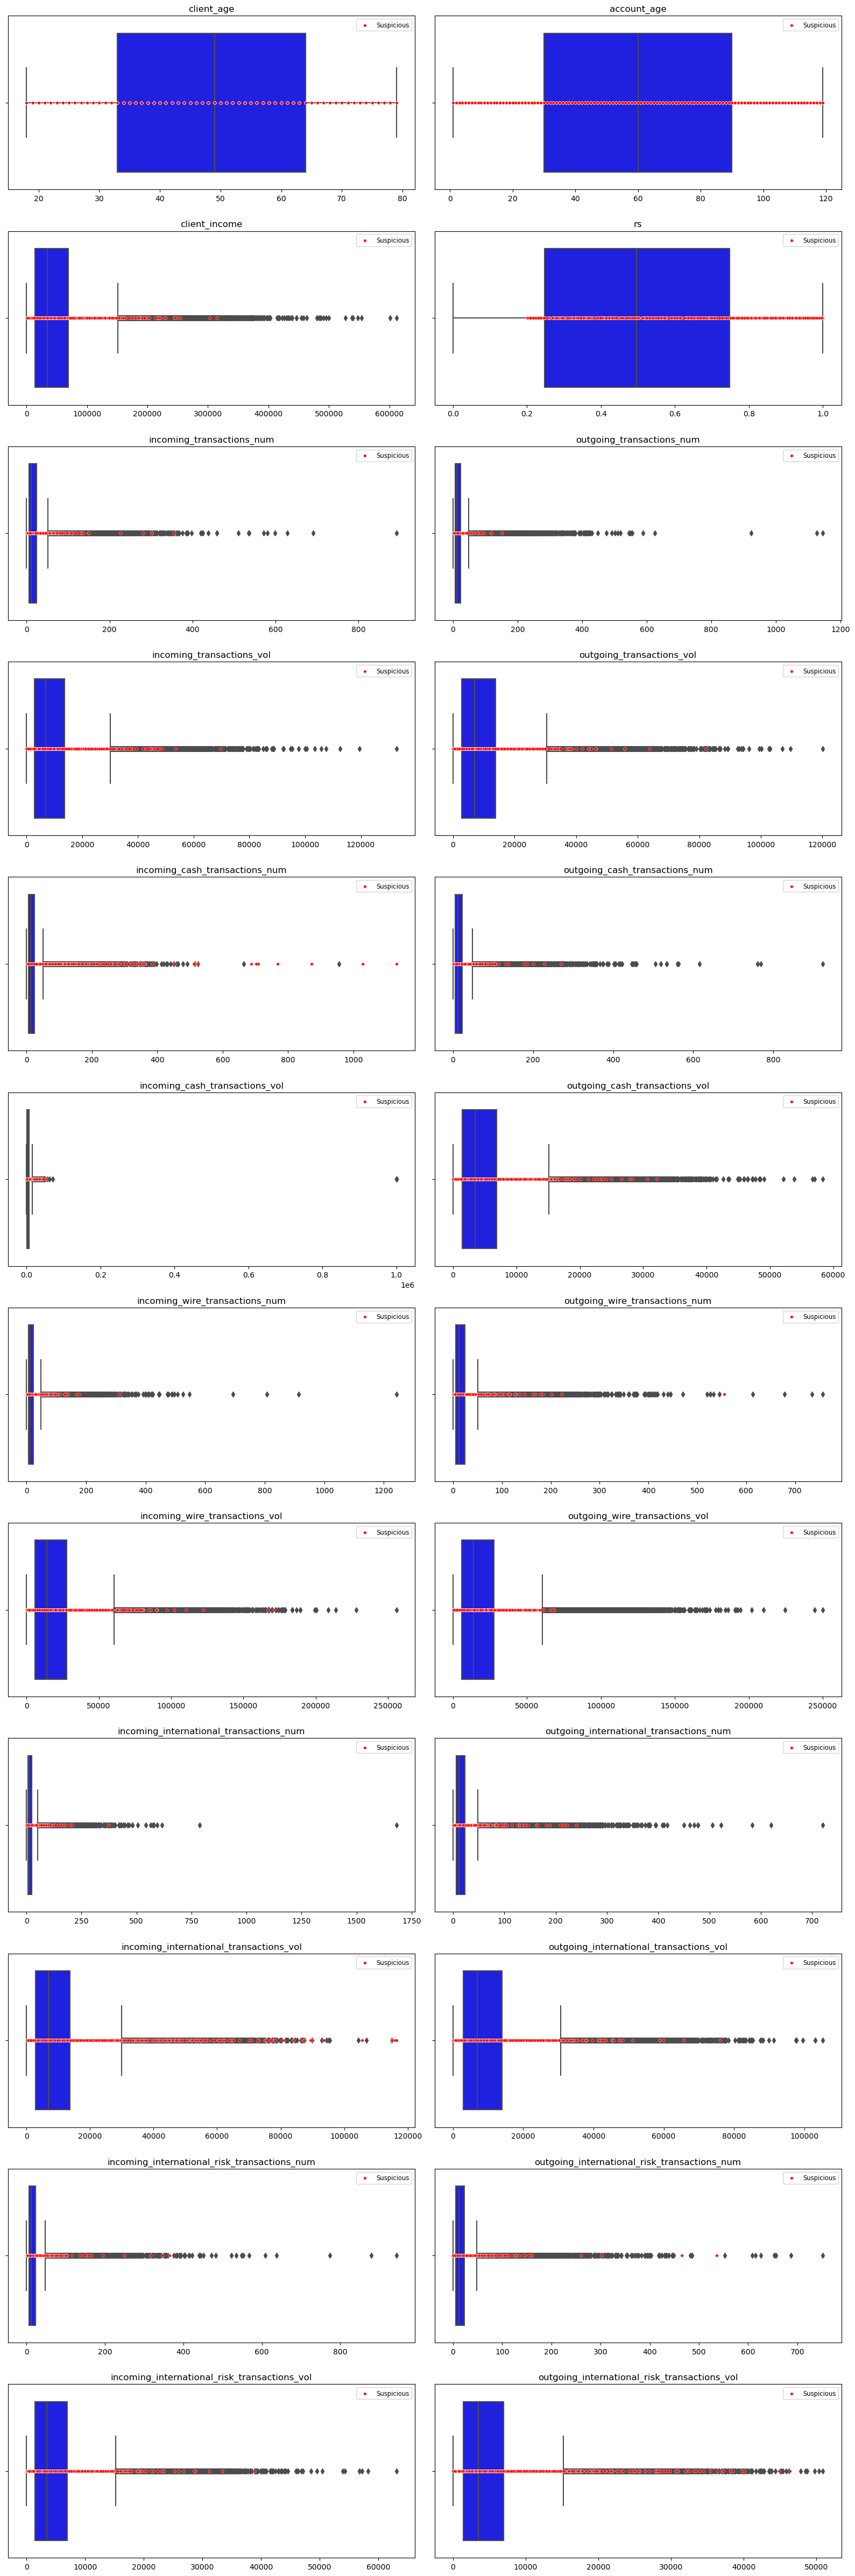

In [54]:
n_cols = 2
n_rows = math.ceil(len(numeric_columns) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.boxplot(
        x=non_flagged_clients_dataset[col], 
        ax=axes[i], 
        color='blue', 
        zorder=1
    )

    sns.scatterplot(
        x=flagged_suspicious_clients_dataset[col],
        y=[0] * len(flagged_suspicious_clients_dataset),
        color='red',
        ax=axes[i],
        s=15,
        label='Suspicious',
        zorder=2
    )

    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].legend(loc='upper right', fontsize='small')

for j in range(len(numeric_columns), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

**Outliers in Transaction Columns**
- All of the transaction-related columns show **extreme outliers**. The maximum values are significantly distant from the interquartile range (IQR), as observed from the long whiskers and isolated points in the plots.
- Columns like `incoming_transactions_vol` and `outgoing_transactions_vol` have unusually high maximum values relative to the median, indicating accounts handling disproportionately large volumes of money.
- The biggest overlaps of flagged suspicious clients with the non-flagged clients in outliers are in `incoming_cash_transactions_num`, `incoming_international_transactions_vol`, and `outgoing_international_risk_transactions_vol`, which suggest that suspicious clients are engaging in unusual patterns of cross-border or high-risk transactions. The overlap with non-flagged outliers indicates that these behaviors may be indicative of suspicious activity even in cases where clients have not been previously flagged, highlighting the importance of including these features in predictive models for detecting potentially fraudulent or high-risk clients.
- However, many of the flagged suspicious clients exhibit signs of normal behavior, as evidenced by their presence within the interquartile range (IQR). This suggests that not all outliers can be clearly classified as suspicious, highlighting the complexity of distinguishing between typical high-value clients and potentially fraudulent activity. Therefore, while outliers can be indicative of unusual behavior, we cannot rely solely on them to flag suspicious clients without considering other factors.
- Distributions Across Columns - Outliers appear across both the **number of transactions** and their **volumes**, suggesting not just high activity but potentially deliberate **structuring of transactions**.

**client_age, account_age, rs**
- There are no outliers in the `client_age` column, and the flagged suspicious clients span a wide range of ages. This suggests that `client_age` may not be very helpful in identifying suspicious clients.
- There are no outliers in the `account_age` column, and the already flagged suspicious clients have accounts of varying ages. This indicates that `account_age` may not be a strong feature for identifying suspicious clients.
- Flagged suspicious clients begin to show a risk level score starting from approximately 0.2, suggesting that this threshold may serve as a useful reference for identifying clients with potential suspicious activity.

**Extreme Client Income**
- `client_income` shows outliers as well. The maximum value (`314531.0`) is an order of magnitude higher than the mean (`51628.27`).
- These clients may represent high-net-worth individuals, but they might also indicate flagged behavior.

**Decisions**
- Given the task of identifying suspicious clients, **outliers are essential**, as they likely represent atypical behavior linked to potential laundering activities. But it is necessary to keep in mind that suspicious clients also exhibit signs of normal behavior.

#### Visualization of distributions using histograms

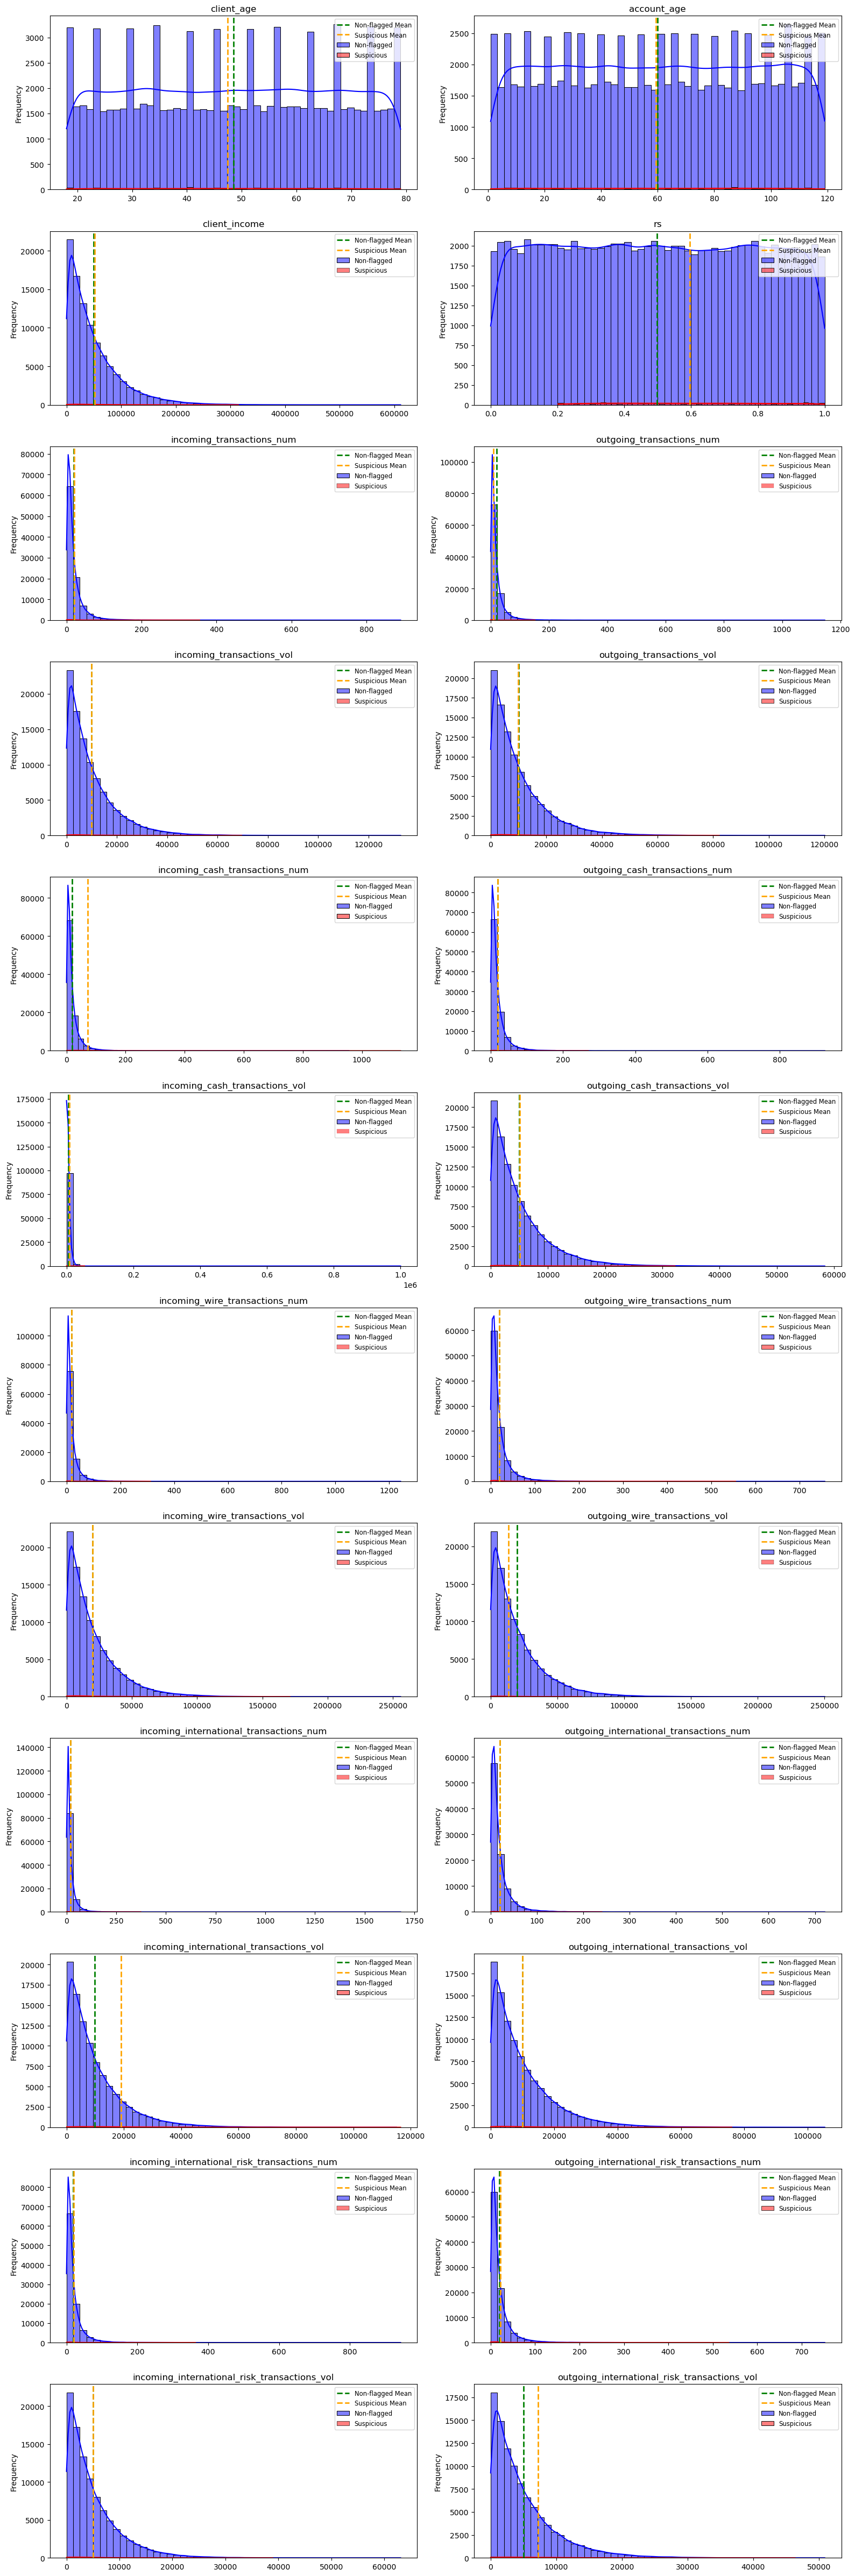

In [55]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.histplot(non_flagged_clients_dataset[col], kde=True, bins=50, ax=axes[i], color='blue', label='Non-flagged')
    sns.histplot(flagged_suspicious_clients_dataset[col], kde=True, bins=50, ax=axes[i], color='red', label='Suspicious')

    
    axes[i].axvline(non_flagged_clients_dataset[col].mean(), color='green', linestyle='dashed', linewidth=2, label='Non-flagged Mean')

    axes[i].axvline(flagged_suspicious_clients_dataset[col].mean(), color='orange', linestyle='dashed', linewidth=2, label='Suspicious Mean')

    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frequency')
    axes[i].legend(loc='upper right', fontsize='small')

for j in range(len(numeric_columns), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

**Transaction Columns are Highly Skewed**
- Almost all transaction-related columns exhibit heavy **right skewness**, as seen in the histograms and summary statistics (e.g., `incoming_cash_transactions_vol` has a skew of `76.39`).
- A large proportion of clients have **low transaction counts**, while a small group engages in significantly higher activities.

**Client Income**
- The income distribution is heavily **right-skewed**, with most clients earning below the mean (`49927.42`).
- The high standard deviation (`49856.51`) and maximum value indicate a small subset of **disproportionately wealthy clients**.

**Client and Account Age**
- `client_age` and `account_age` are uniformly distributed, with no significant deviations or suspicious patterns. These columns may not contribute heavily to distinguishing suspicious clients.

**Feature Prioritization**
- I will focus on **transaction-related features** for predictive modelling, as these show meaningful variability and are most directly linked to suspicious activity.

#### Visualization of class distributions for categorical columns: `gender` and `nationality_group`

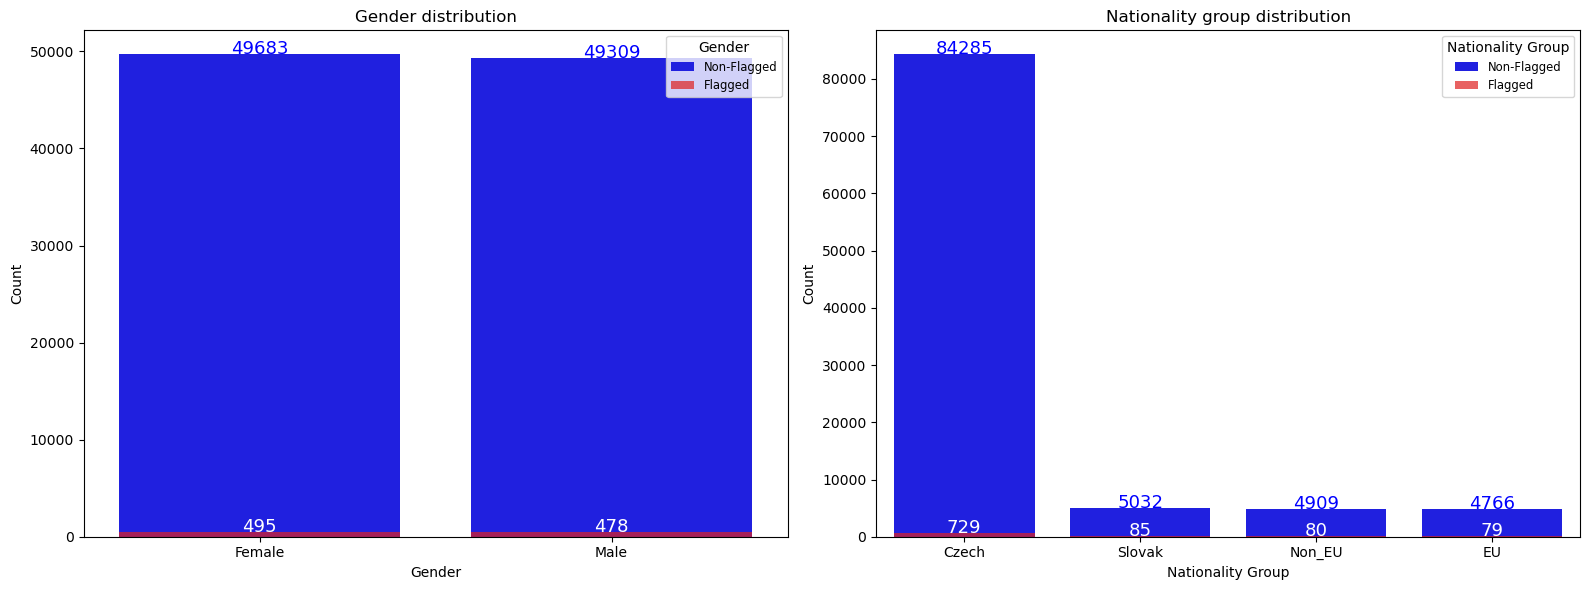

In [56]:
non_flagged_gender_counts = non_flagged_clients_dataset['gender'].value_counts()
flagged_gender_counts = flagged_suspicious_clients_dataset['gender'].value_counts()

non_flagged_nationality_counts = non_flagged_clients_dataset['nationality_group'].value_counts()
flagged_nationality_counts = flagged_suspicious_clients_dataset['nationality_group'].value_counts()

categories = [
    ('Gender distribution', non_flagged_gender_counts, flagged_gender_counts, 'Gender'),
    ('Nationality group distribution', non_flagged_nationality_counts, flagged_nationality_counts, 'Nationality Group')
]

n_cols = 2
n_rows = math.ceil(len(categories) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6 * n_rows))
axes = axes.flatten()

for i, (title, non_flagged_counts, flagged_counts, xlabel) in enumerate(categories):
    sns.barplot(
        x=non_flagged_counts.index,
        y=non_flagged_counts.values,
        ax=axes[i],
        color='blue',
        label='Non-Flagged',
        zorder=1
    )
    sns.barplot(
        x=flagged_counts.index,
        y=flagged_counts.values,
        ax=axes[i],
        color='red',
        alpha=0.7,
        label='Flagged',
        zorder=2
    )

    for index, value in enumerate(non_flagged_counts.values):
        axes[i].text(index, value + 1, str(value), ha='center', color='blue', fontsize=13)
    for index, value in enumerate(flagged_counts.values):
        axes[i].text(index, value + 1, str(value), ha='center', color='white', fontsize=13)

    axes[i].set_title(title)
    axes[i].set_xlabel(xlabel)
    axes[i].set_ylabel('Count')
    axes[i].legend(title=xlabel, loc='upper right', fontsize='small')

for j in range(len(categories), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [57]:
combined_gender_counts = pd.DataFrame({
    'Non-Flagged': non_flagged_gender_counts,
    'Flagged': flagged_gender_counts
}).fillna(0)
gender_percentage = combined_gender_counts.div(combined_gender_counts.sum(axis=1), axis=0) * 100

combined_nationality_counts = pd.DataFrame({
    'Non-Flagged': non_flagged_nationality_counts,
    'Flagged': flagged_nationality_counts
}).fillna(0)
nationality_percentage = combined_nationality_counts.div(combined_nationality_counts.sum(axis=1), axis=0) * 100

print('Nationality Group Proportions (%):')
nationality_percentage

Nationality Group Proportions (%):


,Non-Flagged,Flagged
nationality_group,,
Czech,99.142494,0.857506
EU,98.416199,1.583801
Non_EU,98.349154,1.650846
Slovak,98.338870,1.661130


In [58]:
print('Gender Proportions (%):')
gender_percentage

Gender Proportions (%):


,Non-Flagged,Flagged
gender,,
Female,99.006104,0.993896
Male,99.047068,0.952932


**Gender Distribution**:  
- The dataset shows a nearly equal split between males (49,683 non-flagged, 495 suspicious) and females (49,309 non-flagged, 478 suspicious).  
- Proportions reveal that **0.95% of males** and **0.99% of females** are flagged as suspicious, indicating a slightly higher percentage of flagged clients among females.  
- This balanced gender representation minimizes the risk of bias, promoting fair and inclusive modeling.

**Nationality Groups**:  
- `'Czech'` is the largest group, with 84,285 non-flagged and 729 suspicious clients, followed by `'Slovak'` (5,032 non-flagged, 85 suspicious).  
- The `'EU'` group accounts for 4,909 non-flagged and 80 suspicious clients, while `'Non-EU'` comprises 4,766 non-flagged and 79 suspicious.  
- Proportions show that **0.86% of Czech nationals**, **1.66% of Slovak nationals**, **1.58% of EU nationals**, and **1.65% of Non-EU nationals** are flagged as suspicious.  
- While Slovak nationals and the Non-EU group have slightly higher rates of suspicious activity, the overall dominance of Czech nationals in the dataset means flagged activity will likely still involve them.  

**Key Insight**:  
- Although flagged suspicious clients are distributed across all categories, there is slightly higher percentage of suspicious activity among Slovak and Non-EU groups.
- Gender-wise, females exhibit a marginally higher rate of suspicious activity, but the difference is not substantial.

#### Visualization of relationships between selected features

The selected pairs of features represent key relationships between risk scores, transaction patterns, and client behavior. These variables were chosen for their potential to indicate fraudulent activity or unusual patterns, as supported by domain knowledge and exploratory analysis. I did not want to plot all pairs because it would result in 276 plots, which would be overwhelming and potentially confusing.

In [59]:
non_flagged_clients_dataset['label'] = 'Non-Flagged'
flagged_suspicious_clients_dataset['label'] = 'Flagged'

combined_dataset = pd.concat([non_flagged_clients_dataset, flagged_suspicious_clients_dataset])

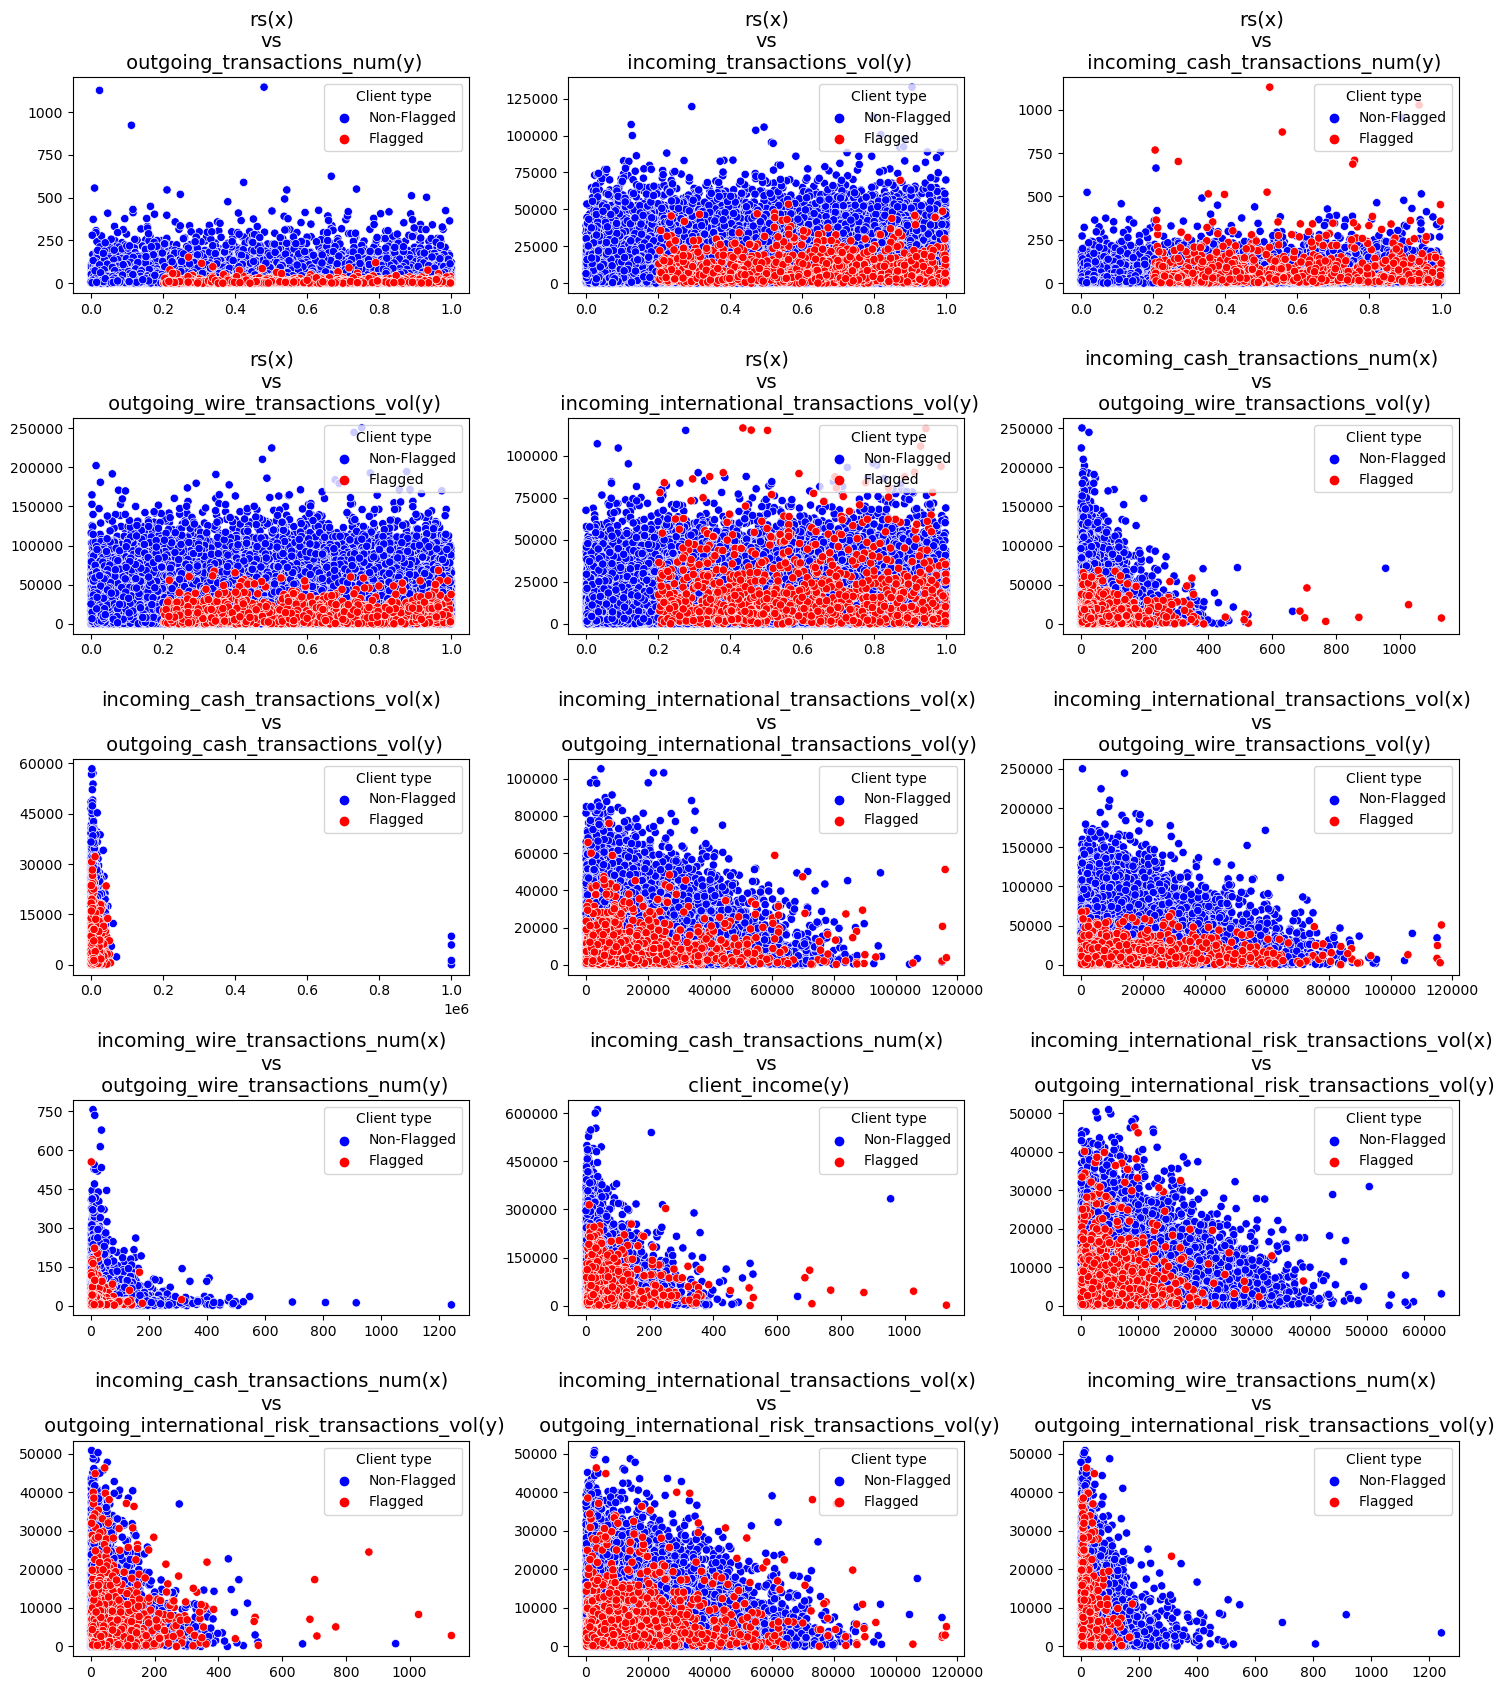

In [60]:
pairs = [
    ('rs', 'outgoing_transactions_num'),
    ('rs', 'incoming_transactions_vol'),
    ('rs', 'incoming_cash_transactions_num'),
    ('rs', 'outgoing_wire_transactions_vol'),
    ('rs', 'incoming_international_transactions_vol'),
    ('incoming_cash_transactions_num', 'outgoing_wire_transactions_vol'),
    ('incoming_cash_transactions_vol', 'outgoing_cash_transactions_vol'),
    ('incoming_international_transactions_vol', 'outgoing_international_transactions_vol'),
    ('incoming_international_transactions_vol', 'outgoing_wire_transactions_vol'),
    ('incoming_wire_transactions_num', 'outgoing_wire_transactions_num'),
    ('incoming_cash_transactions_num', 'client_income'),
    ('incoming_international_risk_transactions_vol', 'outgoing_international_risk_transactions_vol'),
    ('incoming_cash_transactions_num', 'outgoing_international_risk_transactions_vol'),
    ('incoming_international_transactions_vol', 'outgoing_international_risk_transactions_vol'),
    ('incoming_wire_transactions_num', 'outgoing_international_risk_transactions_vol')
]

num_rows = 5
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 17))
axes = axes.flatten()

for i, (x_col, y_col) in enumerate(pairs):
    sns.scatterplot(data=combined_dataset, x=x_col, y=y_col, hue='label', palette={'Non-Flagged': 'blue', 'Flagged': 'red'}, ax=axes[i])
    axes[i].set_title(f'{x_col}(x)\nvs\n {y_col}(y)', fontsize=14)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].yaxis.set_major_locator(MaxNLocator(nbins=6))
    axes[i].legend(title='Client type', loc='upper right')

for j in range(len(pairs), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

non_flagged_clients_dataset = non_flagged_clients_dataset.drop(columns=['label'])
flagged_suspicious_clients_dataset = flagged_suspicious_clients_dataset.drop(columns=['label'])
combined_dataset = combined_dataset.drop(columns=['label'])

- **Risk score vs Transaction patterns:**
    - Flagged clients cluster in regions of low transaction volume and counts across all types (cash, wire, international), and span a range from 0.2 of risk scores, suggesting a correlation between lower transaction activity and higher likelihood of being flagged for unusual or potentially fraudulent behavior.

- **Cash transactions (volume and count):**
    - Non-flagged clients dominate high-volume cash transactions, indicating legitimate business operations, while flagged clients remain confined to low-volume regions.

- **Wire transactions:**
    - Proportional trends exist between incoming and outgoing wire transactions, with flagged clients exhibiting fewer total transactions, likely indicating limited activity channels.

- **Income vs Transactions:**
    - Flagged clients show lower income, contrasting with the wider distribution of non-flagged clients, who dominate higher-income. There are some outliers among suspicious clients, who have higher number of incoming cash transactions.

- **International transactions:**
    - Flagged clients remain concentrated at lower transaction volumes, especially for international risk transactions, but mostly correlate with non-suspicious clients.

- **Key differentiators:**
    - Volume of Activity: Flagged suspicious clients consistently operate on a smaller scale.
    - Concentration: Behavior of suspicious clients is concentrated in low-volume, high-risk areas, while non-flagged clients activity is diverse and spread across higher transaction volumes.

#### Visualization of correlation between features

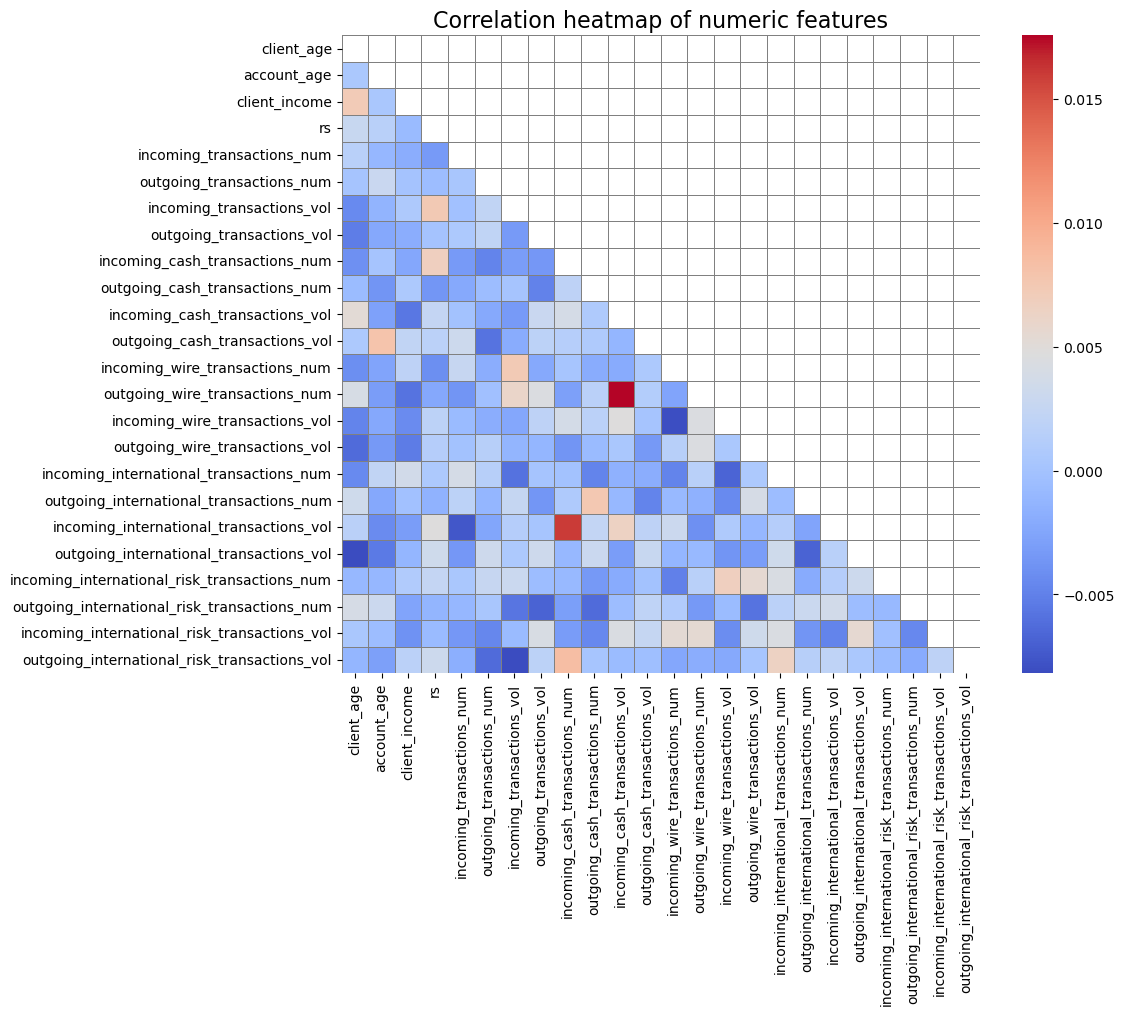

In [61]:
corr_matrix = combined_dataset[numeric_columns].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=0)

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap='coolwarm',
    annot_kws={'size': 7},
    linewidths=0.5,
    linecolor='gray',
    cbar=True,
    square=True
)

plt.title('Correlation heatmap of numeric features', fontsize=16)
plt.tight_layout()
plt.show()

There is no correlation in between all of the columns, suggesting that the transaction behaviors and client demographics are independent. These differences highlight the importance of combining diverse features for identifying suspicious activity.

---

## **Feature Engineering and Modelling**

In [62]:
combined_dataset = pd.concat([
    flagged_suspicious_clients_dataset.assign(flagged=1),
    non_flagged_clients_dataset.assign(flagged=0)
])

combined_dataset

,client_id,client_age,account_age,client_income,gender,rs,incoming_transactions_num,outgoing_transactions_num,incoming_transactions_vol,outgoing_transactions_vol,incoming_cash_transactions_num,outgoing_cash_transactions_num,incoming_cash_transactions_vol,outgoing_cash_transactions_vol,incoming_wire_transactions_num,outgoing_wire_transactions_num,incoming_wire_transactions_vol,outgoing_wire_transactions_vol,incoming_international_transactions_num,outgoing_international_transactions_num,incoming_international_transactions_vol,outgoing_international_transactions_vol,incoming_international_risk_transactions_num,outgoing_international_risk_transactions_num,incoming_international_risk_transactions_vol,outgoing_international_risk_transactions_vol,nationality_group,flagged
43,70099,18,42,59713,Male,0.771503,76.0,2.0,8501,4222,43,3,9509,10624,19,12,11755,45756,29,1,3331,868,12,17,9405,46354,Czech,1
321,50315,23,99,7026,Male,0.590442,7.0,1.0,12627,2928,148,5,14182,3713,7,2,15118,9801,10,45,20027,4040,6,49,9930,7710,Czech,1
357,14179,53,19,113386,Male,0.575050,9.0,3.0,2393,5923,14,1,1631,10842,15,14,3865,32770,13,3,6587,123,7,51,9483,6024,EU,1
389,26947,28,10,51147,Female,0.304548,24.0,23.0,23633,1414,62,53,3150,9801,29,11,34665,17104,60,41,923,5677,5,10,4046,548,Czech,1
457,37637,21,66,11096,Female,0.864281,80.0,1.0,13808,3515,81,28,951,1690,22,33,1528,42893,28,13,12052,3255,166,15,2522,11540,Slovak,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,4636,46,104,10521,Female,0.417748,9.0,7.0,2878,6846,22,42,659,3572,11,8,4295,1808,1,6,20383,3937,33,16,2979,11343,Czech,0
99996,15954,69,116,62383,Male,0.565244,1.0,18.0,27253,11036,15,31,91,17561,4,24,1642,19248,14,83,23971,1949,17,2,26716,51,Czech,0
99997,1709,37,108,32813,Female,0.616270,21.0,36.0,514,14010,5,29,125,7042,5,13,31129,26838,9,8,817,3234,20,17,4692,1492,Czech,0
99998,89085,58,89,117888,Female,0.914122,6.0,43.0,1249,12314,11,5,12643,4207,14,1,1653,1400,7,8,7680,1451,43,100,438,4742,Czech,0


### **1. Technique of feature engineering - Added new features**

In [ ]:
client_ids = combined_dataset['client_id'].values

combined_dataset_added_features = combined_dataset.copy()

combined_dataset_added_features['incoming_outgoing_ratio'] = combined_dataset_added_features['incoming_transactions_num'] / (combined_dataset_added_features['outgoing_transactions_num'] + 1)
combined_dataset_added_features['cash_transaction_ratio'] = combined_dataset_added_features['incoming_cash_transactions_num'] / (combined_dataset_added_features['incoming_transactions_num'] + 1)
combined_dataset_added_features['high_risk_ratio'] = combined_dataset_added_features['incoming_international_risk_transactions_num'] / (combined_dataset_added_features['incoming_international_transactions_num'] + 1)
combined_dataset_added_features['international_volume_ratio'] = combined_dataset_added_features['incoming_international_transactions_vol'] / (combined_dataset_added_features['incoming_transactions_vol'] + 1)
combined_dataset_added_features['normalized_risk_score'] = combined_dataset_added_features['rs'] / (combined_dataset_added_features['client_income'] + 1)

engineered_features = [
    'incoming_outgoing_ratio', 'cash_transaction_ratio', 'high_risk_ratio', 
    'international_volume_ratio', 'normalized_risk_score'
]

all_features = numeric_columns + engineered_features

scaler_added_features = MinMaxScaler()
scaled_features_added_features = scaler_added_features.fit_transform(combined_dataset_added_features[all_features])

scaled_data_added_features = pd.DataFrame(scaled_features_added_features, columns=all_features)
scaled_data_added_features['flagged'] = combined_dataset_added_features['flagged'].values
scaled_data_added_features['client_id'] = client_ids

flagged_data_added_features = scaled_data_added_features[scaled_data_added_features['flagged'] == 1].drop(columns=['flagged'])
non_flagged_data_added_features = scaled_data_added_features[scaled_data_added_features['flagged'] == 0].drop(columns=['flagged'])

I decided to add new features to enhance the dataset's ability to capture meaningful patterns and relationships that might not be evident with the original features alone. These features are designed to provide additional context and granularity. Specifically:

- **Incoming-Outgoing Ratio**: To assess the balance between incoming and outgoing transactions, which could indicate unusual activity.
- **Cash Transaction Ratio**: To highlight the proportion of cash transactions, as high cash activity might signal risk.
- **High-Risk Ratio**: To evaluate the frequency of high-risk transactions within international activities, a key factor in identifying suspicious behavior.
- **International Volume Ratio**: To capture the proportion of international transaction volume, as unusual international activity can be a red flag.
- **Normalized Risk Score**: To standardize the risk score relative to client income, ensuring fair comparison across different income levels.

#### Modelling - Semi-supervised learning

I decided to use these models for semi-supervised learning because they are well-suited for anomaly detection tasks where labeled data is limited. These models complement each other by using different approaches to capture anomalies. This enhances the robustness of the anomaly detection process:

- **Autoencoder**: I chose an autoencoder because it learns a compressed representation of the data, enabling it to reconstruct normal patterns effectively. Anomalies can then be detected as instances with high reconstruction errors, making it ideal for identifying deviations in the data.
- **One-Class SVM**: I selected the One-Class SVM because it models the distribution of normal data points using a boundary in a high-dimensional space. It is effective for distinguishing anomalies as points lying outside this boundary.
- **Isolation Forest**: I included the Isolation Forest because it isolates anomalies by randomly partitioning the feature space. It is efficient, and works well when the anomalies are sparse and different from the majority of the data.

##### Autoencoder model

In [64]:
input_dim = flagged_data_added_features.shape[1] - 1

autoencoder = keras.models.Sequential([
    keras.layers.Dense(64, activation='relu', input_dim=input_dim),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(input_dim, activation='sigmoid')
])

autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

flagged_data_no_id_added_features = flagged_data_added_features.drop(columns=['client_id'])
autoencoder.fit(flagged_data_no_id_added_features, flagged_data_no_id_added_features,
                epochs=50, batch_size=32,
                verbose=0)

Reconstruction error for Autoencoder

In [65]:
# Reconstruction error for Autoencoder
reconstruction_flagged = autoencoder.predict(flagged_data_no_id_added_features)
error_flagged_autoencoder = np.mean(np.square(flagged_data_no_id_added_features - reconstruction_flagged), axis=1)

non_flagged_data_no_id = non_flagged_data_added_features.drop(columns=['client_id'])
reconstruction_unlabeled = autoencoder.predict(non_flagged_data_no_id)
error_non_flagged_autoencoder = np.mean(np.square(non_flagged_data_no_id - reconstruction_unlabeled), axis=1)

non_flagged_data_added_features['Suspiciousness_autoencoder'] = error_non_flagged_autoencoder

# Extract top 100 suspicious clients for Autoencoder
top_100_suspicious_autoencoder = non_flagged_data_added_features.sort_values(by='Suspiciousness_autoencoder', ascending=False).head(100)
original_values_autoencoder = scaler_added_features.inverse_transform(top_100_suspicious_autoencoder[all_features])

top_100_original_values_autoencoder = pd.DataFrame(original_values_autoencoder, columns=all_features)
top_100_original_values_autoencoder['client_id'] = top_100_suspicious_autoencoder['client_id'].values
top_100_original_values_autoencoder['Suspiciousness'] = top_100_suspicious_autoencoder['Suspiciousness_autoencoder'].values

top_100_original_values_autoencoder

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
3094/3094 ━━━━━━━━━━━━━━━━━━━━ 2s 761us/step


,client_age,account_age,client_income,rs,incoming_transactions_num,outgoing_transactions_num,incoming_transactions_vol,outgoing_transactions_vol,incoming_cash_transactions_num,outgoing_cash_transactions_num,incoming_cash_transactions_vol,outgoing_cash_transactions_vol,incoming_wire_transactions_num,outgoing_wire_transactions_num,incoming_wire_transactions_vol,outgoing_wire_transactions_vol,incoming_international_transactions_num,outgoing_international_transactions_num,incoming_international_transactions_vol,outgoing_international_transactions_vol,incoming_international_risk_transactions_num,outgoing_international_risk_transactions_num,incoming_international_risk_transactions_vol,outgoing_international_risk_transactions_vol,incoming_outgoing_ratio,cash_transaction_ratio,high_risk_ratio,international_volume_ratio,normalized_risk_score,client_id,Suspiciousness
0,55.0,10.0,32330.0,0.665851,4.0,20.0,902.0,23473.0,23.0,4.0,3938.0,13247.0,20.0,7.0,65865.0,12745.0,0.0,3.0,5969.0,6536.0,552.0,12.0,13099.0,12789.0,0.190476,4.600000,552.000000,6.610188,2.059481e-05,89330,0.048642
1,59.0,29.0,12814.0,0.792854,8.0,17.0,4162.0,4267.0,15.0,50.0,1000000.0,8499.0,13.0,311.0,17135.0,54085.0,40.0,14.0,1330.0,171.0,15.0,3.0,9915.0,878.0,0.444444,1.666667,0.365854,0.319481,6.186918e-05,5015,0.042892
2,41.0,91.0,7687.0,0.858384,5.0,14.0,18282.0,18741.0,4.0,1.0,13598.0,4318.0,25.0,12.0,13334.0,12367.0,3.0,19.0,35320.0,14849.0,943.0,59.0,340.0,2716.0,0.333333,0.666667,235.750000,1.931849,1.116524e-04,3900,0.041308
3,79.0,25.0,0.0,0.566001,26.0,9.0,5250.0,4113.0,20.0,0.0,5317.0,2790.0,4.0,16.0,33046.0,2636.0,23.0,7.0,3455.0,1064.0,9.0,11.0,17293.0,1195.0,2.600000,0.740741,0.375000,0.657970,5.660014e-01,44091,0.040339
4,72.0,51.0,30145.0,0.513115,5.0,48.0,5464.0,2693.0,6.0,4.0,1000000.0,31.0,9.0,83.0,70835.0,1253.0,17.0,32.0,26597.0,5422.0,2.0,5.0,10905.0,3654.0,0.102041,1.000000,0.111111,4.866789,1.702101e-05,19646,0.039516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,42.0,65.0,600932.0,0.055432,34.0,1.0,5906.0,1348.0,29.0,8.0,11725.0,222.0,16.0,8.0,4788.0,1051.0,4.0,24.0,9814.0,1403.0,9.0,23.0,11790.0,4571.0,17.000000,0.828571,1.800000,1.661419,9.224348e-08,78937,0.018625
96,61.0,57.0,94075.0,0.522683,6.0,13.0,9284.0,22886.0,4.0,1.0,3612.0,47321.0,17.0,8.0,24158.0,12682.0,13.0,5.0,76219.0,6168.0,14.0,30.0,2490.0,8106.0,0.428571,0.571429,1.000000,8.208831,5.555963e-06,95988,0.018585
97,76.0,68.0,49921.0,0.005070,65.0,7.0,1062.0,1266.0,13.0,18.0,17390.0,45247.0,13.0,41.0,54.0,25439.0,11.0,87.0,1897.0,11277.0,80.0,48.0,12412.0,892.0,8.125000,0.196970,6.666667,1.784572,1.015571e-07,91222,0.018553
98,25.0,109.0,112258.0,0.034798,96.0,44.0,1252.0,43622.0,4.0,3.0,1169.0,4417.0,6.0,3.0,11174.0,99024.0,17.0,20.0,592.0,219.0,522.0,16.0,2303.0,3420.0,2.133333,0.041237,29.000000,0.472466,3.099784e-07,34059,0.018509


##### One class SVM model

In [66]:
svm_model = OneClassSVM(
    kernel='rbf',
    gamma=0.02,
    nu=0.1
)

svm_model.fit(flagged_data_no_id_added_features)

anomaly_scores_svm = -svm_model.decision_function(non_flagged_data_no_id)
non_flagged_data_added_features['Suspiciousness_svm'] = anomaly_scores_svm

top_100_suspicious_svm = non_flagged_data_added_features.sort_values(by='Suspiciousness_svm', ascending=False).head(100)
original_values_svm = scaler_added_features.inverse_transform(top_100_suspicious_svm[all_features])

top_100_original_values_svm = pd.DataFrame(original_values_svm, columns=all_features)
top_100_original_values_svm['client_id'] = top_100_suspicious_svm['client_id'].values
top_100_original_values_svm['Suspiciousness'] = top_100_suspicious_svm['Suspiciousness_svm'].values

top_100_original_values_svm

,client_age,account_age,client_income,rs,incoming_transactions_num,outgoing_transactions_num,incoming_transactions_vol,outgoing_transactions_vol,incoming_cash_transactions_num,outgoing_cash_transactions_num,incoming_cash_transactions_vol,outgoing_cash_transactions_vol,incoming_wire_transactions_num,outgoing_wire_transactions_num,incoming_wire_transactions_vol,outgoing_wire_transactions_vol,incoming_international_transactions_num,outgoing_international_transactions_num,incoming_international_transactions_vol,outgoing_international_transactions_vol,incoming_international_risk_transactions_num,outgoing_international_risk_transactions_num,incoming_international_risk_transactions_vol,outgoing_international_risk_transactions_vol,incoming_outgoing_ratio,cash_transaction_ratio,high_risk_ratio,international_volume_ratio,normalized_risk_score,client_id,Suspiciousness
0,64.0,106.0,35411.0,0.140195,7.0,4.0,3.0,3507.0,39.0,10.0,900.0,11538.0,4.0,5.0,94.0,34883.0,3.0,16.0,81691.0,2648.0,90.0,6.0,4028.0,3913.0,1.400000,4.875000,22.500000,20422.750000,3.958961e-06,56061,2.178800
1,55.0,10.0,32330.0,0.665851,4.0,20.0,902.0,23473.0,23.0,4.0,3938.0,13247.0,20.0,7.0,65865.0,12745.0,0.0,3.0,5969.0,6536.0,552.0,12.0,13099.0,12789.0,0.190476,4.600000,552.000000,6.610188,2.059481e-05,89330,2.048183
2,79.0,25.0,186287.0,0.317683,211.0,0.0,14990.0,863.0,8.0,5.0,5979.0,871.0,12.0,7.0,8905.0,32231.0,8.0,18.0,5436.0,6602.0,11.0,52.0,714.0,526.0,211.000000,0.037736,1.222222,0.362618,1.705331e-06,71127,2.012421
3,69.0,47.0,17678.0,0.000168,29.0,6.0,1343.0,15274.0,55.0,924.0,2925.0,8039.0,11.0,54.0,10984.0,5456.0,18.0,8.0,14033.0,35702.0,19.0,2.0,2353.0,2686.0,4.142857,1.833333,1.000000,10.441220,9.500514e-09,60363,1.942277
4,78.0,29.0,18553.0,0.221339,29.0,13.0,452.0,8494.0,9.0,29.0,1000000.0,1281.0,10.0,101.0,3467.0,3932.0,5.0,9.0,6187.0,9118.0,29.0,5.0,2031.0,4710.0,2.071429,0.300000,4.833333,13.657837,1.192947e-05,51870,1.903705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,73.0,114.0,110066.0,0.027991,10.0,3.0,1893.0,25345.0,7.0,32.0,8377.0,1349.0,43.0,25.0,18430.0,105290.0,4.0,11.0,346.0,43856.0,3.0,3.0,4880.0,7251.0,2.500000,0.636364,0.600000,0.182682,2.543101e-07,74824,0.952853
96,76.0,119.0,8993.0,0.013918,306.0,28.0,469.0,11393.0,32.0,8.0,8433.0,2575.0,7.0,17.0,4501.0,8750.0,5.0,15.0,4003.0,407.0,6.0,11.0,11741.0,864.0,10.551724,0.104235,1.000000,8.517021,1.547470e-06,59753,0.951637
97,29.0,35.0,16078.0,0.241115,31.0,8.0,142.0,6672.0,16.0,3.0,149.0,3659.0,2.0,9.0,21080.0,1296.0,3.0,126.0,1864.0,1431.0,1.0,2.0,50457.0,30903.0,3.444444,0.500000,0.250000,13.034965,1.499563e-05,83827,0.951110
98,33.0,17.0,7554.0,0.361004,112.0,5.0,26697.0,11130.0,9.0,9.0,1499.0,352.0,1.0,7.0,20421.0,12228.0,277.0,1.0,20101.0,97797.0,77.0,50.0,483.0,1221.0,18.666667,0.079646,0.276978,0.752903,4.778341e-05,89103,0.936193


##### Isolation forest model

In [67]:
forest_model = IsolationForest(
    n_estimators=200, 
    contamination=0.05, 
    max_samples='auto', 
    random_state=42
)

forest_model.fit(flagged_data_no_id_added_features)

anomaly_scores_forest = -forest_model.decision_function(non_flagged_data_no_id)
non_flagged_data_added_features['Suspiciousness_forest'] = anomaly_scores_forest

top_100_suspicious_forest = non_flagged_data_added_features.sort_values(by='Suspiciousness_forest', ascending=False).head(100)
original_values_forest = scaler_added_features.inverse_transform(top_100_suspicious_forest[all_features])

top_100_original_values_forest = pd.DataFrame(original_values_forest, columns=all_features)
top_100_original_values_forest['client_id'] = top_100_suspicious_forest['client_id'].values
top_100_original_values_forest['Suspiciousness'] = top_100_suspicious_forest['Suspiciousness_forest'].values

top_100_original_values_forest

,client_age,account_age,client_income,rs,incoming_transactions_num,outgoing_transactions_num,incoming_transactions_vol,outgoing_transactions_vol,incoming_cash_transactions_num,outgoing_cash_transactions_num,incoming_cash_transactions_vol,outgoing_cash_transactions_vol,incoming_wire_transactions_num,outgoing_wire_transactions_num,incoming_wire_transactions_vol,outgoing_wire_transactions_vol,incoming_international_transactions_num,outgoing_international_transactions_num,incoming_international_transactions_vol,outgoing_international_transactions_vol,incoming_international_risk_transactions_num,outgoing_international_risk_transactions_num,incoming_international_risk_transactions_vol,outgoing_international_risk_transactions_vol,incoming_outgoing_ratio,cash_transaction_ratio,high_risk_ratio,international_volume_ratio,normalized_risk_score,client_id,Suspiciousness
0,78.0,10.0,242191.0,0.151539,4.0,4.0,37036.0,28617.0,19.0,297.0,1055.0,2367.0,6.0,66.0,34289.0,5298.0,4.0,5.0,411.0,4050.0,204.0,5.0,2401.0,11867.0,0.800000,3.800000,40.800000,0.011097,6.256992e-07,72412,0.096905
1,26.0,107.0,17393.0,0.758889,224.0,69.0,9106.0,10026.0,17.0,17.0,3101.0,14053.0,7.0,14.0,36706.0,39936.0,2.0,78.0,4528.0,1037.0,277.0,22.0,3178.0,1741.0,3.200000,0.075556,92.333333,0.497200,4.362934e-05,50970,0.094971
2,60.0,16.0,455.0,0.956888,4.0,8.0,15.0,3977.0,50.0,11.0,5426.0,823.0,58.0,4.0,88755.0,69544.0,24.0,3.0,9403.0,45129.0,5.0,86.0,572.0,7510.0,0.444444,10.000000,0.200000,587.687500,2.098439e-03,10124,0.092933
3,60.0,81.0,257942.0,0.794169,2.0,12.0,22769.0,1826.0,68.0,53.0,19756.0,7692.0,44.0,15.0,39011.0,43362.0,226.0,334.0,3220.0,5398.0,46.0,2.0,20203.0,6162.0,0.153846,22.666667,0.202643,0.141414,3.078855e-06,98368,0.089554
4,24.0,113.0,129666.0,0.203177,275.0,5.0,32792.0,409.0,58.0,49.0,11114.0,708.0,26.0,20.0,6738.0,46787.0,313.0,6.0,15456.0,12649.0,10.0,2.0,3807.0,19375.0,45.833333,0.210145,0.031847,0.471320,1.566916e-06,97542,0.088791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,44.0,115.0,37379.0,0.058382,37.0,17.0,15633.0,12068.0,23.0,9.0,7107.0,911.0,23.0,40.0,2913.0,92162.0,1.0,17.0,1859.0,48463.0,100.0,6.0,7077.0,908.0,2.055556,0.605263,50.000000,0.118908,1.561846e-06,72880,0.046576
96,61.0,97.0,70493.0,0.804906,7.0,3.0,36119.0,14604.0,2.0,136.0,3681.0,1390.0,314.0,143.0,8183.0,43824.0,10.0,54.0,29013.0,3861.0,12.0,48.0,16654.0,9921.0,1.750000,0.250000,1.090909,0.803239,1.141807e-05,3988,0.046378
97,64.0,106.0,35411.0,0.140195,7.0,4.0,3.0,3507.0,39.0,10.0,900.0,11538.0,4.0,5.0,94.0,34883.0,3.0,16.0,81691.0,2648.0,90.0,6.0,4028.0,3913.0,1.400000,4.875000,22.500000,20422.750000,3.958961e-06,56061,0.046335
98,45.0,86.0,45286.0,0.074079,13.0,96.0,8308.0,17752.0,57.0,3.0,2184.0,217.0,33.0,2.0,7523.0,54023.0,68.0,222.0,11315.0,32802.0,4.0,122.0,730.0,214.0,0.134021,4.071429,0.057971,1.361776,1.635766e-06,20209,0.046280


### **2. Technique of feature engineering - Encoding categorical columns**

In [ ]:
# One-hot encoding categorical columns
categorical_columns = ['gender', 'nationality_group']
numeric_columns_categorical_features = numeric_columns + list(pd.get_dummies(combined_dataset[categorical_columns]).columns)

combined_dataset_categorical_features = combined_dataset.copy()

combined_dataset_encoded = pd.get_dummies(combined_dataset, columns=categorical_columns)

scaler_categorical_features = MinMaxScaler()
scaled_features_categorical_features = scaler_categorical_features.fit_transform(combined_dataset_encoded[numeric_columns_categorical_features])

scaled_data_categorical_features = pd.DataFrame(scaled_features_categorical_features, columns=numeric_columns_categorical_features)
scaled_data_categorical_features['flagged'] = combined_dataset_encoded['flagged'].values
scaled_data_categorical_features['client_id'] = combined_dataset_encoded['client_id'].values

flagged_data_categorical_features = scaled_data_categorical_features[scaled_data_categorical_features['flagged'] == 1].drop(columns=['flagged'])
non_flagged_data_categorical_features = scaled_data_categorical_features[scaled_data_categorical_features['flagged'] == 0].drop(columns=['flagged'])


I decided to encode categorical columns to utilize categorical information, which cannot be directly interpreted in its original form. Specifically:

- **One-Hot Encoding**: I used one-hot encoding for categorical columns (`gender`, `nationality_group`) to represent these variables as binary indicators.
- **Expanded Feature Set**: By including the one-hot-encoded features, I enriched the dataset with additional features that capture group-specific information, potentially improving model performance.
- **Integration with Numeric Features**: The one-hot-encoded columns were combined with the original numeric features.
- **Reason for Choosing One-Hot Encoding**: I selected one-hot encoding over other techniques, such as label encoding or target encoding, because it avoids introducing any implicit ordinal relationships or numerical biases between categories.

#### Modelling

##### Autoencoder model

In [69]:
input_dim_categorical = flagged_data_categorical_features.shape[1] - 1

autoencoder_categorical = keras.models.Sequential([
    keras.layers.Dense(64, activation='relu', input_dim=input_dim_categorical),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(input_dim_categorical, activation='sigmoid')
])

autoencoder_categorical.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

flagged_data_no_id_categorical_features = flagged_data_categorical_features.drop(columns=['client_id'])
autoencoder_categorical.fit(flagged_data_no_id_categorical_features, flagged_data_no_id_categorical_features,
                            epochs=50, batch_size=32, verbose=0)

# Reconstruction error for Autoencoder
reconstruction_flagged_categorical = autoencoder_categorical.predict(flagged_data_no_id_categorical_features)
error_flagged_autoencoder_categorical = np.mean(np.square(flagged_data_no_id_categorical_features - reconstruction_flagged_categorical), axis=1)

non_flagged_data_no_id_categorical_features = non_flagged_data_categorical_features.drop(columns=['client_id'])
reconstruction_unlabeled_categorical = autoencoder_categorical.predict(non_flagged_data_no_id_categorical_features)
error_non_flagged_autoencoder_categorical = np.mean(np.square(non_flagged_data_no_id_categorical_features - reconstruction_unlabeled_categorical), axis=1)

non_flagged_data_categorical_features['Suspiciousness_autoencoder'] = error_non_flagged_autoencoder_categorical

# Extract top 100 suspicious clients for Autoencoder
top_100_suspicious_autoencoder_categorical = non_flagged_data_categorical_features.sort_values(by='Suspiciousness_autoencoder', ascending=False).head(100)
original_values_autoencoder_categorical = scaler_categorical_features.inverse_transform(top_100_suspicious_autoencoder_categorical[numeric_columns_categorical_features])

top_100_original_values_autoencoder_categorical = pd.DataFrame(original_values_autoencoder_categorical, columns=numeric_columns_categorical_features)
top_100_original_values_autoencoder_categorical['client_id'] = top_100_suspicious_autoencoder_categorical['client_id'].values
top_100_original_values_autoencoder_categorical['Suspiciousness'] = top_100_suspicious_autoencoder_categorical['Suspiciousness_autoencoder'].values
top_100_original_values_autoencoder_categorical

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
3094/3094 ━━━━━━━━━━━━━━━━━━━━ 2s 775us/step


,client_age,account_age,client_income,rs,incoming_transactions_num,outgoing_transactions_num,incoming_transactions_vol,outgoing_transactions_vol,incoming_cash_transactions_num,outgoing_cash_transactions_num,incoming_cash_transactions_vol,outgoing_cash_transactions_vol,incoming_wire_transactions_num,outgoing_wire_transactions_num,incoming_wire_transactions_vol,outgoing_wire_transactions_vol,incoming_international_transactions_num,outgoing_international_transactions_num,incoming_international_transactions_vol,outgoing_international_transactions_vol,incoming_international_risk_transactions_num,outgoing_international_risk_transactions_num,incoming_international_risk_transactions_vol,outgoing_international_risk_transactions_vol,gender_Female,gender_Male,nationality_group_Czech,nationality_group_EU,nationality_group_Non_EU,nationality_group_Slovak,client_id,Suspiciousness
0,31.0,74.0,127655.0,0.451284,20.0,57.0,4637.0,23910.0,28.0,26.0,4490.0,318.0,6.0,48.0,40061.0,73967.0,27.0,7.0,3464.0,97588.0,18.0,26.0,18851.0,4360.0,0.0,1.0,1.0,0.0,0.0,0.0,65742,0.054448
1,59.0,29.0,12814.0,0.792854,8.0,17.0,4162.0,4267.0,15.0,50.0,1000000.0,8499.0,13.0,311.0,17135.0,54085.0,40.0,14.0,1330.0,171.0,15.0,3.0,9915.0,878.0,0.0,1.0,0.0,0.0,1.0,0.0,5015,0.042803
2,34.0,29.0,6033.0,0.452194,18.0,26.0,8163.0,34576.0,7.0,12.0,1000000.0,5910.0,10.0,16.0,21908.0,14077.0,20.0,19.0,6631.0,2275.0,4.0,12.0,19099.0,1382.0,0.0,1.0,0.0,0.0,0.0,1.0,84004,0.038357
3,72.0,51.0,30145.0,0.513115,5.0,48.0,5464.0,2693.0,6.0,4.0,1000000.0,31.0,9.0,83.0,70835.0,1253.0,17.0,32.0,26597.0,5422.0,2.0,5.0,10905.0,3654.0,0.0,1.0,0.0,1.0,0.0,0.0,19646,0.037332
4,19.0,101.0,23894.0,0.295774,5.0,8.0,787.0,1802.0,15.0,10.0,57.0,4324.0,2.0,7.0,20102.0,24276.0,11.0,5.0,4826.0,105318.0,3.0,31.0,6136.0,8841.0,0.0,1.0,0.0,0.0,0.0,1.0,67935,0.036683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,31.0,27.0,33160.0,0.480370,5.0,15.0,1504.0,14594.0,15.0,4.0,2111.0,3144.0,3.0,4.0,213861.0,19026.0,9.0,9.0,5826.0,27825.0,73.0,36.0,1791.0,2842.0,0.0,1.0,1.0,0.0,0.0,0.0,10990,0.019593
96,26.0,55.0,495335.0,0.435179,38.0,8.0,3602.0,6619.0,48.0,6.0,809.0,12804.0,9.0,2.0,14417.0,6039.0,40.0,12.0,2309.0,14972.0,7.0,6.0,82.0,1180.0,1.0,0.0,1.0,0.0,0.0,0.0,8503,0.019573
97,62.0,105.0,463296.0,0.925478,4.0,54.0,1095.0,2518.0,6.0,12.0,410.0,6230.0,8.0,2.0,17255.0,12063.0,14.0,13.0,3696.0,13573.0,22.0,210.0,2107.0,2778.0,1.0,0.0,1.0,0.0,0.0,0.0,97888,0.019548
98,48.0,118.0,210241.0,0.856209,12.0,22.0,32998.0,31.0,19.0,3.0,512.0,986.0,24.0,1.0,2207.0,37074.0,7.0,4.0,18457.0,64598.0,13.0,39.0,2654.0,1244.0,1.0,0.0,0.0,1.0,0.0,0.0,32637,0.019531


##### One class SVM model

In [70]:
svm_model_categorical = OneClassSVM(
    kernel='rbf',
    gamma=0.02,
    nu=0.1
)

svm_model_categorical.fit(flagged_data_no_id_categorical_features)

anomaly_scores_svm_categorical = -svm_model_categorical.decision_function(non_flagged_data_no_id_categorical_features)
non_flagged_data_categorical_features['Suspiciousness_svm'] = anomaly_scores_svm_categorical

top_100_suspicious_svm_categorical = non_flagged_data_categorical_features.sort_values(by='Suspiciousness_svm', ascending=False).head(100)
original_values_svm_categorical = scaler_categorical_features.inverse_transform(top_100_suspicious_svm_categorical[numeric_columns_categorical_features])

top_100_original_values_svm_categorical = pd.DataFrame(original_values_svm_categorical, columns=numeric_columns_categorical_features)
top_100_original_values_svm_categorical['client_id'] = top_100_suspicious_svm_categorical['client_id'].values
top_100_original_values_svm_categorical['Suspiciousness'] = top_100_suspicious_svm_categorical['Suspiciousness_svm'].values
top_100_original_values_svm_categorical

,client_age,account_age,client_income,rs,incoming_transactions_num,outgoing_transactions_num,incoming_transactions_vol,outgoing_transactions_vol,incoming_cash_transactions_num,outgoing_cash_transactions_num,incoming_cash_transactions_vol,outgoing_cash_transactions_vol,incoming_wire_transactions_num,outgoing_wire_transactions_num,incoming_wire_transactions_vol,outgoing_wire_transactions_vol,incoming_international_transactions_num,outgoing_international_transactions_num,incoming_international_transactions_vol,outgoing_international_transactions_vol,incoming_international_risk_transactions_num,outgoing_international_risk_transactions_num,incoming_international_risk_transactions_vol,outgoing_international_risk_transactions_vol,gender_Female,gender_Male,nationality_group_Czech,nationality_group_EU,nationality_group_Non_EU,nationality_group_Slovak,client_id,Suspiciousness
0,73.0,30.0,38466.0,0.012274,4.0,40.0,5970.0,2400.0,46.0,12.0,2504.0,58359.0,6.0,2.0,16354.0,40658.0,21.0,35.0,5110.0,2052.0,15.0,6.0,45.0,491.0,1.0,0.0,0.0,1.0,0.0,0.0,67462,1.966026
1,59.0,29.0,12814.0,0.792854,8.0,17.0,4162.0,4267.0,15.0,50.0,1000000.0,8499.0,13.0,311.0,17135.0,54085.0,40.0,14.0,1330.0,171.0,15.0,3.0,9915.0,878.0,0.0,1.0,0.0,0.0,1.0,0.0,5015,1.814321
2,69.0,47.0,17678.0,0.000168,29.0,6.0,1343.0,15274.0,55.0,924.0,2925.0,8039.0,11.0,54.0,10984.0,5456.0,18.0,8.0,14033.0,35702.0,19.0,2.0,2353.0,2686.0,0.0,1.0,1.0,0.0,0.0,0.0,60363,1.664781
3,78.0,29.0,18553.0,0.221339,29.0,13.0,452.0,8494.0,9.0,29.0,1000000.0,1281.0,10.0,101.0,3467.0,3932.0,5.0,9.0,6187.0,9118.0,29.0,5.0,2031.0,4710.0,1.0,0.0,1.0,0.0,0.0,0.0,51870,1.657207
4,61.0,94.0,9587.0,0.011881,34.0,70.0,3423.0,15207.0,5.0,1.0,2630.0,12102.0,1242.0,3.0,5750.0,42153.0,9.0,45.0,19274.0,3543.0,27.0,2.0,3899.0,3532.0,1.0,0.0,1.0,0.0,0.0,0.0,77625,1.586203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,39.0,6.0,12303.0,0.006268,5.0,47.0,16779.0,1467.0,51.0,1.0,1098.0,33136.0,7.0,25.0,25894.0,15239.0,20.0,22.0,1106.0,7481.0,2.0,70.0,807.0,5499.0,1.0,0.0,0.0,1.0,0.0,0.0,83903,0.844684
96,71.0,85.0,53451.0,0.086964,33.0,21.0,3933.0,18798.0,8.0,16.0,7712.0,40683.0,10.0,5.0,866.0,5797.0,19.0,32.0,7432.0,19314.0,4.0,6.0,2935.0,12844.0,1.0,0.0,0.0,1.0,0.0,0.0,41075,0.838641
97,18.0,100.0,14250.0,0.165718,86.0,9.0,28035.0,14742.0,6.0,41.0,3499.0,4910.0,16.0,13.0,5519.0,4044.0,19.0,3.0,4446.0,81142.0,2.0,10.0,18935.0,2720.0,0.0,1.0,1.0,0.0,0.0,0.0,85625,0.838476
98,79.0,6.0,201907.0,0.108356,27.0,28.0,6532.0,2184.0,2.0,9.0,3639.0,5652.0,2.0,13.0,2185.0,32003.0,15.0,10.0,3903.0,12283.0,14.0,27.0,955.0,15922.0,0.0,1.0,0.0,0.0,0.0,1.0,21691,0.838270


##### Isolation forest model

In [71]:
forest_model_categorical = IsolationForest(
    n_estimators=200,
    contamination=0.05,
    max_samples='auto',
    random_state=42
)

forest_model_categorical.fit(flagged_data_no_id_categorical_features)

anomaly_scores_forest_categorical = -forest_model_categorical.decision_function(non_flagged_data_no_id_categorical_features)
non_flagged_data_categorical_features['Suspiciousness_forest'] = anomaly_scores_forest_categorical

top_100_suspicious_forest_categorical = non_flagged_data_categorical_features.sort_values(by='Suspiciousness_forest', ascending=False).head(100)
original_values_forest_categorical = scaler_categorical_features.inverse_transform(top_100_suspicious_forest_categorical[numeric_columns_categorical_features])

top_100_original_values_forest_categorical = pd.DataFrame(original_values_forest_categorical, columns=numeric_columns_categorical_features)
top_100_original_values_forest_categorical['client_id'] = top_100_suspicious_forest_categorical['client_id'].values
top_100_original_values_forest_categorical['Suspiciousness'] = top_100_suspicious_forest_categorical['Suspiciousness_forest'].values
top_100_original_values_forest_categorical

,client_age,account_age,client_income,rs,incoming_transactions_num,outgoing_transactions_num,incoming_transactions_vol,outgoing_transactions_vol,incoming_cash_transactions_num,outgoing_cash_transactions_num,incoming_cash_transactions_vol,outgoing_cash_transactions_vol,incoming_wire_transactions_num,outgoing_wire_transactions_num,incoming_wire_transactions_vol,outgoing_wire_transactions_vol,incoming_international_transactions_num,outgoing_international_transactions_num,incoming_international_transactions_vol,outgoing_international_transactions_vol,incoming_international_risk_transactions_num,outgoing_international_risk_transactions_num,incoming_international_risk_transactions_vol,outgoing_international_risk_transactions_vol,gender_Female,gender_Male,nationality_group_Czech,nationality_group_EU,nationality_group_Non_EU,nationality_group_Slovak,client_id,Suspiciousness
0,58.0,65.0,3751.0,0.247758,36.0,335.0,57036.0,23018.0,7.0,113.0,941.0,5795.0,19.0,7.0,3498.0,28851.0,71.0,13.0,25500.0,29161.0,66.0,9.0,1716.0,20539.0,0.0,1.0,0.0,1.0,0.0,0.0,55210,0.098834
1,61.0,97.0,70493.0,0.804906,7.0,3.0,36119.0,14604.0,2.0,136.0,3681.0,1390.0,314.0,143.0,8183.0,43824.0,10.0,54.0,29013.0,3861.0,12.0,48.0,16654.0,9921.0,1.0,0.0,0.0,0.0,0.0,1.0,3988,0.094571
2,35.0,8.0,173232.0,0.180818,5.0,77.0,8841.0,42511.0,11.0,204.0,1309.0,2230.0,19.0,8.0,994.0,36827.0,9.0,1.0,18832.0,37682.0,30.0,5.0,3088.0,1360.0,1.0,0.0,0.0,1.0,0.0,0.0,51173,0.092046
3,26.0,107.0,17393.0,0.758889,224.0,69.0,9106.0,10026.0,17.0,17.0,3101.0,14053.0,7.0,14.0,36706.0,39936.0,2.0,78.0,4528.0,1037.0,277.0,22.0,3178.0,1741.0,0.0,1.0,0.0,1.0,0.0,0.0,50970,0.091537
4,32.0,117.0,35252.0,0.168942,9.0,62.0,37354.0,789.0,22.0,153.0,3281.0,112.0,8.0,1.0,13109.0,26231.0,8.0,69.0,4299.0,11117.0,61.0,5.0,823.0,1510.0,0.0,1.0,0.0,1.0,0.0,0.0,20469,0.089077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,79.0,21.0,14107.0,0.434968,19.0,17.0,4816.0,9987.0,3.0,23.0,5688.0,2380.0,4.0,18.0,94762.0,39409.0,207.0,10.0,15646.0,11165.0,43.0,7.0,16600.0,1321.0,0.0,1.0,0.0,0.0,1.0,0.0,94624,0.055851
96,32.0,59.0,30084.0,0.266889,7.0,16.0,6767.0,734.0,31.0,27.0,4930.0,1844.0,76.0,14.0,20923.0,14739.0,113.0,10.0,20475.0,30609.0,31.0,132.0,489.0,38847.0,0.0,1.0,0.0,1.0,0.0,0.0,27514,0.055836
97,31.0,52.0,46102.0,0.491522,1.0,189.0,4138.0,23953.0,47.0,12.0,1492.0,2395.0,51.0,73.0,5292.0,8187.0,2.0,104.0,19224.0,2150.0,47.0,66.0,2931.0,4092.0,0.0,1.0,0.0,0.0,0.0,1.0,67543,0.055817
98,67.0,86.0,36106.0,0.494084,23.0,10.0,55810.0,1766.0,8.0,113.0,592.0,1062.0,14.0,26.0,12389.0,75091.0,21.0,28.0,31639.0,85.0,51.0,16.0,12655.0,3009.0,0.0,1.0,0.0,0.0,0.0,1.0,87359,0.055736


### **3. Technique of feature engineering - Only selected features**

based on the analysis

In [ ]:
selected_features = [
    'rs', 'outgoing_transactions_num', 'incoming_cash_transactions_num', 
    'incoming_cash_transactions_vol', 'outgoing_wire_transactions_vol', 
    'incoming_international_transactions_vol', 'incoming_international_risk_transactions_num', 
    'outgoing_international_risk_transactions_num', 'outgoing_international_risk_transactions_vol'
]

combined_dataset_selected_features = combined_dataset[selected_features + ['client_id', 'flagged']].copy()

scaler_selected_features = MinMaxScaler()
scaled_features_selected_features = scaler_selected_features.fit_transform(combined_dataset_selected_features[selected_features])

scaled_data_selected_features = pd.DataFrame(scaled_features_selected_features, columns=selected_features)
scaled_data_selected_features['flagged'] = combined_dataset_selected_features['flagged'].values
scaled_data_selected_features['client_id'] = combined_dataset_selected_features['client_id'].values

flagged_data_selected_features = scaled_data_selected_features[scaled_data_selected_features['flagged'] == 1].drop(columns=['flagged'])
non_flagged_data_selected_features = scaled_data_selected_features[scaled_data_selected_features['flagged'] == 0].drop(columns=['flagged'])

I decided to focus on only selected features to streamline the dataset and emphasize the most informative variables for the task. Specifically:

- **Selected Features**: These features were identified through analysis as showing the greatest differences between flagged (suspicious) and non-flagged clients, making them crucial for distinguishing patterns of interest.
- **Efficient Scaling**: The reduced feature set also ensures computational efficiency while maintaining data integrity.

#### Modelling

##### Autoencoder model

In [73]:
input_dim_selected = flagged_data_selected_features.shape[1] - 1

autoencoder_selected = keras.models.Sequential([
    keras.layers.Dense(64, activation='relu', input_dim=input_dim_selected),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(input_dim_selected, activation='sigmoid')
])

autoencoder_selected.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

flagged_data_no_id_selected_features = flagged_data_selected_features.drop(columns=['client_id'])
autoencoder_selected.fit(flagged_data_no_id_selected_features, flagged_data_no_id_selected_features,
                         epochs=50, batch_size=32, verbose=0)

# Reconstruction error for Autoencoder
reconstruction_flagged_selected = autoencoder_selected.predict(flagged_data_no_id_selected_features)
error_flagged_autoencoder_selected = np.mean(np.square(flagged_data_no_id_selected_features - reconstruction_flagged_selected), axis=1)

non_flagged_data_no_id_selected_features = non_flagged_data_selected_features.drop(columns=['client_id'])
reconstruction_unlabeled_selected = autoencoder_selected.predict(non_flagged_data_no_id_selected_features)
error_non_flagged_autoencoder_selected = np.mean(np.square(non_flagged_data_no_id_selected_features - reconstruction_unlabeled_selected), axis=1)

non_flagged_data_selected_features['Suspiciousness_autoencoder'] = error_non_flagged_autoencoder_selected

# Extract top 100 suspicious clients for Autoencoder
top_100_suspicious_autoencoder_selected = non_flagged_data_selected_features.sort_values(by='Suspiciousness_autoencoder', ascending=False).head(100)
original_values_autoencoder_selected = scaler_selected_features.inverse_transform(top_100_suspicious_autoencoder_selected[selected_features])

top_100_original_values_autoencoder_selected = pd.DataFrame(original_values_autoencoder_selected, columns=selected_features)
top_100_original_values_autoencoder_selected['client_id'] = top_100_suspicious_autoencoder_selected['client_id'].values
top_100_original_values_autoencoder_selected['Suspiciousness'] = top_100_suspicious_autoencoder_selected['Suspiciousness_autoencoder'].values
top_100_original_values_autoencoder_selected

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
3094/3094 ━━━━━━━━━━━━━━━━━━━━ 2s 758us/step


,rs,outgoing_transactions_num,incoming_cash_transactions_num,incoming_cash_transactions_vol,outgoing_wire_transactions_vol,incoming_international_transactions_vol,incoming_international_risk_transactions_num,outgoing_international_risk_transactions_num,outgoing_international_risk_transactions_vol,client_id,Suspiciousness
0,0.513115,48.0,6.0,1000000.0,1253.0,26597.0,2.0,5.0,3654.0,19646,0.114122
1,0.792854,17.0,15.0,1000000.0,54085.0,1330.0,15.0,3.0,878.0,5015,0.114079
2,0.221339,13.0,9.0,1000000.0,3932.0,6187.0,29.0,5.0,4710.0,51870,0.113153
3,0.954335,11.0,6.0,1000000.0,11272.0,14550.0,16.0,7.0,3590.0,68257,0.112692
4,0.452194,26.0,7.0,1000000.0,14077.0,6631.0,4.0,12.0,1382.0,84004,0.112309
...,...,...,...,...,...,...,...,...,...,...,...
95,0.452904,4.0,10.0,12835.0,150175.0,8998.0,24.0,40.0,5487.0,65721,0.040164
96,0.433663,10.0,20.0,2877.0,142918.0,11502.0,38.0,4.0,5686.0,38724,0.040119
97,0.260383,29.0,31.0,473.0,131595.0,4621.0,4.0,16.0,1169.0,64516,0.040006
98,0.719923,45.0,17.0,5618.0,161098.0,2887.0,18.0,4.0,1575.0,87228,0.039831


##### One class SVM model

In [74]:
svm_model_selected = OneClassSVM(
    kernel='rbf',
    gamma=0.02,
    nu=0.1
)

svm_model_selected.fit(flagged_data_no_id_selected_features)

anomaly_scores_svm_selected = -svm_model_selected.decision_function(non_flagged_data_no_id_selected_features)
non_flagged_data_selected_features['Suspiciousness_svm'] = anomaly_scores_svm_selected

top_100_suspicious_svm_selected = non_flagged_data_selected_features.sort_values(by='Suspiciousness_svm', ascending=False).head(100)
original_values_svm_selected = scaler_selected_features.inverse_transform(top_100_suspicious_svm_selected[selected_features])

top_100_original_values_svm_selected = pd.DataFrame(original_values_svm_selected, columns=selected_features)
top_100_original_values_svm_selected['client_id'] = top_100_suspicious_svm_selected['client_id'].values
top_100_original_values_svm_selected['Suspiciousness'] = top_100_suspicious_svm_selected['Suspiciousness_svm'].values
top_100_original_values_svm_selected

,rs,outgoing_transactions_num,incoming_cash_transactions_num,incoming_cash_transactions_vol,outgoing_wire_transactions_vol,incoming_international_transactions_vol,incoming_international_risk_transactions_num,outgoing_international_risk_transactions_num,outgoing_international_risk_transactions_vol,client_id,Suspiciousness
0,0.023754,1127.0,2.0,11858.0,26949.0,8474.0,0.0,32.0,765.0,12096,2.216403
1,0.099070,18.0,10.0,7880.0,20326.0,1364.0,26.0,752.0,1805.0,53228,2.009754
2,0.221339,13.0,9.0,1000000.0,3932.0,6187.0,29.0,5.0,4710.0,51870,1.876683
3,0.792854,17.0,15.0,1000000.0,54085.0,1330.0,15.0,3.0,878.0,5015,1.793635
4,0.954335,11.0,6.0,1000000.0,11272.0,14550.0,16.0,7.0,3590.0,68257,1.787060
...,...,...,...,...,...,...,...,...,...,...,...
95,0.688502,1.0,4.0,6747.0,179497.0,1492.0,6.0,7.0,435.0,22597,0.660363
96,0.004094,38.0,11.0,3884.0,97528.0,5288.0,18.0,18.0,2233.0,13140,0.656768
97,0.022248,28.0,10.0,6744.0,99960.0,1872.0,16.0,9.0,2250.0,97555,0.656163
98,0.925054,66.0,1.0,413.0,17637.0,1773.0,4.0,11.0,43431.0,29445,0.652935


##### Isolation forest model

In [75]:
forest_model_selected = IsolationForest(
    n_estimators=200,
    contamination=0.05,
    max_samples='auto',
    random_state=42
)

forest_model_selected.fit(flagged_data_no_id_selected_features)

anomaly_scores_forest_selected = -forest_model_selected.decision_function(non_flagged_data_no_id_selected_features)
non_flagged_data_selected_features['Suspiciousness_forest'] = anomaly_scores_forest_selected

top_100_suspicious_forest_selected = non_flagged_data_selected_features.sort_values(by='Suspiciousness_forest', ascending=False).head(100)
original_values_forest_selected = scaler_selected_features.inverse_transform(top_100_suspicious_forest_selected[selected_features])

top_100_original_values_forest_selected = pd.DataFrame(original_values_forest_selected, columns=selected_features)
top_100_original_values_forest_selected['client_id'] = top_100_suspicious_forest_selected['client_id'].values
top_100_original_values_forest_selected['Suspiciousness'] = top_100_suspicious_forest_selected['Suspiciousness_forest'].values

## **Evaluation**

I decided to use these metrics and visualization techniques to evaluate the models because they effectively measure clustering quality and provide clear insights into how well the models align flagged suspicious clients with the top 100 most suspicious clients predicted by the models:

- **PCA Visualization**: I used PCA to reduce the data to two dimensions for visualization. This helps me visually assess the alignment between flagged suspicious clients and the top 100 most suspicious clients. Overlap or proximity between these groups in the PCA plot indicates that the model is effectively identifying similar patterns of suspicion.
- **Silhouette Score**: I included the silhouette score to measure how similar a data point is to its own cluster compared to other clusters. The score ranges from -1 to 1, where values closer to 0 indicate that the two groups (flagged and top 100) overlap significantly, which is desirable in this case as it suggests the top 100 clients resemble flagged ones.
- **Cluster Purity**: I used cluster purity to measure the alignment of top 100 with the flagged clients. A higher purity score indicates that the top 100 clients are grouped similarly to flagged clients, which would validate the model's effectiveness.

In [117]:
def evaluate_model_technique(
    flagged_suspicious_clients_dataset, top_100_original_values, numeric_columns, 
    technique_name, model_name
):
    if technique_name == 'selected features':
        combined_data = pd.concat([
            flagged_suspicious_clients_dataset[selected_features],
            top_100_original_values[selected_features]
        ])
    else:
        combined_data = pd.concat([
                flagged_suspicious_clients_dataset[numeric_columns],
                top_100_original_values[numeric_columns]
        ])

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(combined_data)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=pca_result[:len(flagged_suspicious_clients_dataset), 0], 
        y=pca_result[:len(flagged_suspicious_clients_dataset), 1], 
        label='Flagged Suspicious', color='red'
    )
    sns.scatterplot(
        x=pca_result[len(flagged_suspicious_clients_dataset):, 0], 
        y=pca_result[len(flagged_suspicious_clients_dataset):, 1], 
        label='Top 100', color='blue'
    )
    plt.title(f'PCA Comparison - {technique_name} ({model_name})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

    # Silhouette Score
    labels = [0] * len(flagged_suspicious_clients_dataset) + [1] * len(top_100_original_values)
    silhouette = silhouette_score(combined_data, labels)
    print(f'Silhouette Score for {technique_name} ({model_name}): {silhouette:.4f}')

    # KMeans Clustering
    kmeans = KMeans(n_clusters=2, random_state=42)
    clusters = kmeans.fit_predict(combined_data)

    # Cluster Purity
    purity = accuracy_score(labels, clusters)
    print(f'Cluster Purity for {technique_name} ({model_name}): {purity:.4f}')

--------------------------------------------------------------------------------------------------------------------------
-------------------------------- 1. Technique of feature engineering - Added new features --------------------------------
--------------------------------------------------------------------------------------------------------------------------


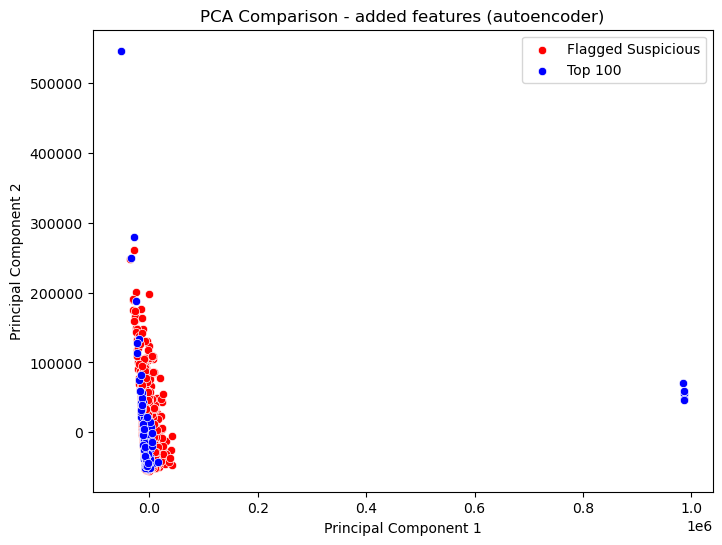

Silhouette Score for added features (autoencoder): 0.4455
Cluster Purity for added features (autoencoder): 0.9115


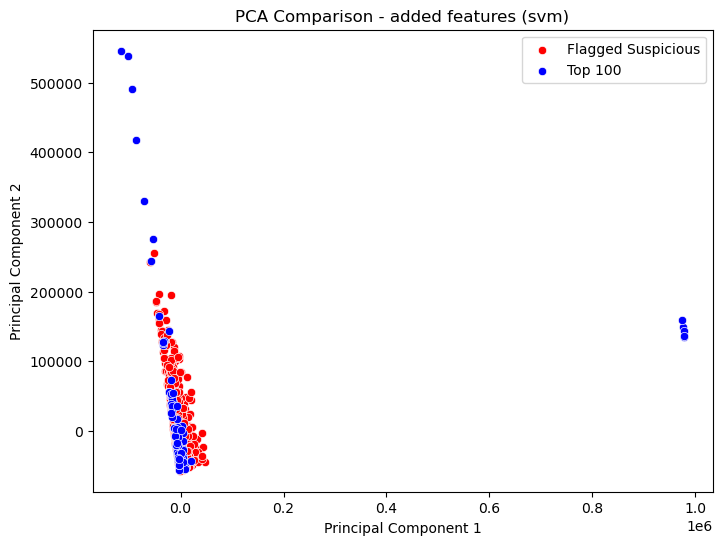

Silhouette Score for added features (svm): 0.4673
Cluster Purity for added features (svm): 0.9115


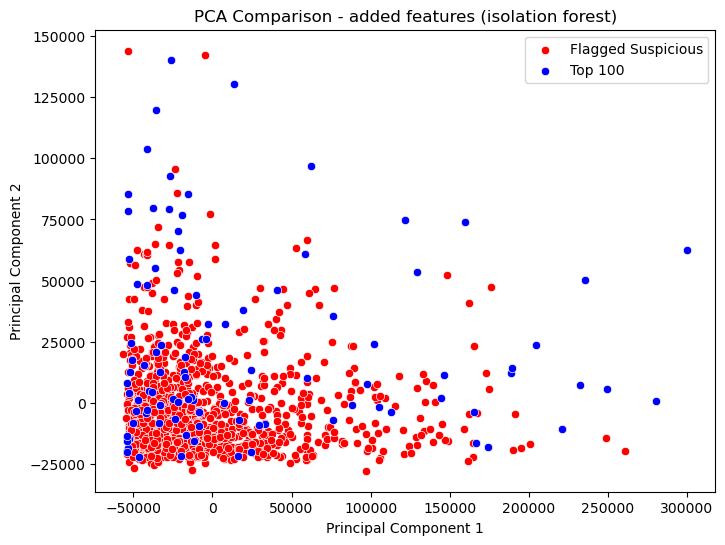

Silhouette Score for added features (isolation forest): 0.2996
Cluster Purity for added features (isolation forest): 0.7801

--------------------------------------------------------------------------------------------------------------------------
-------------------------------- 2. Technique of feature engineering - Encoding categorical columns ----------------------
--------------------------------------------------------------------------------------------------------------------------


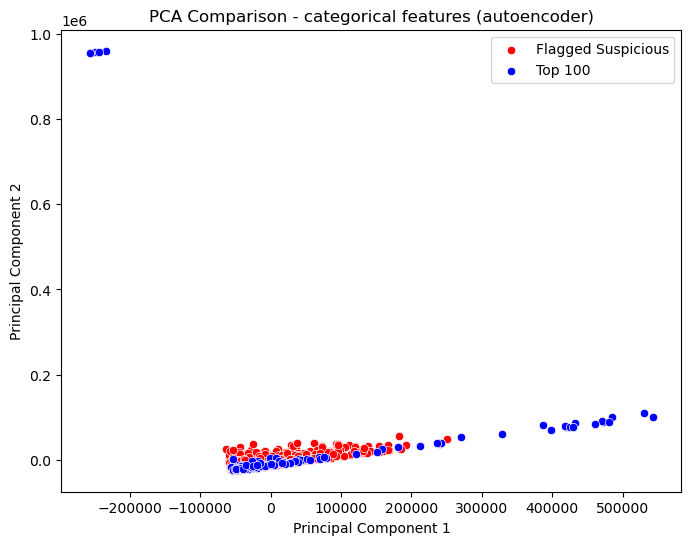

Silhouette Score for categorical features (autoencoder): 0.5491
Cluster Purity for categorical features (autoencoder): 0.9115


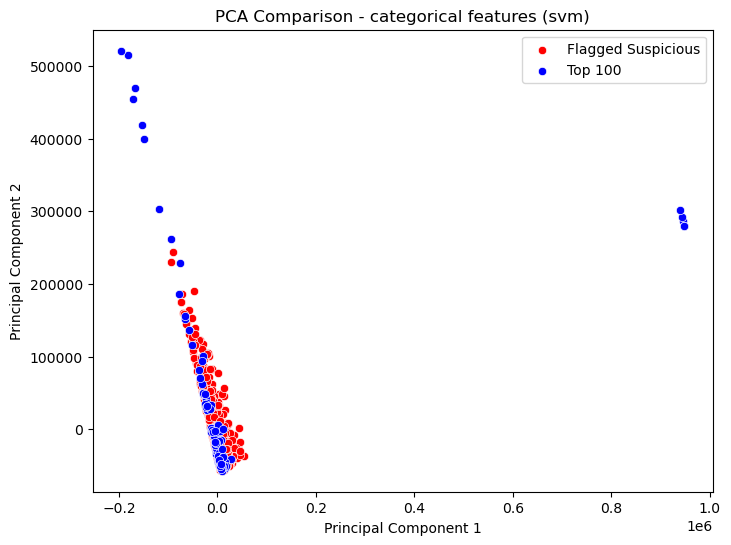

Silhouette Score for categorical features (svm): 0.4884
Cluster Purity for categorical features (svm): 0.9115


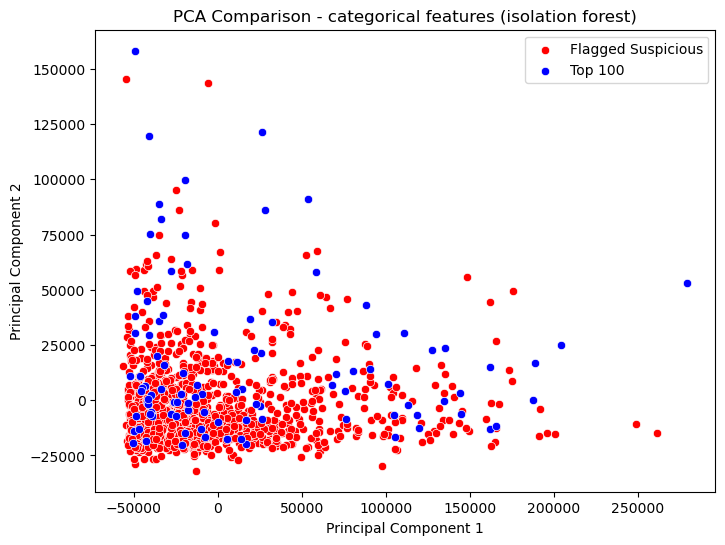

Silhouette Score for categorical features (isolation forest): 0.2374
Cluster Purity for categorical features (isolation forest): 0.7745

--------------------------------------------------------------------------------------------------------------------------
-------------------------------- 3. Technique of feature engineering - Only selected features ----------------------------
--------------------------------------------------------------------------------------------------------------------------


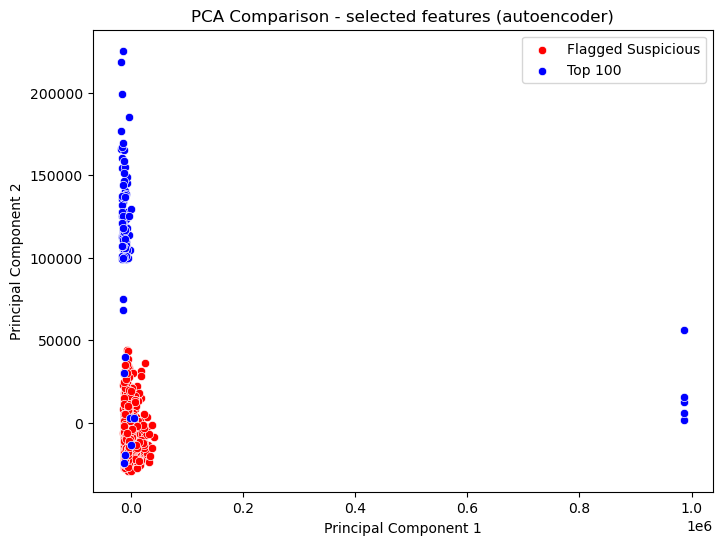

Silhouette Score for selected features (autoencoder): 0.7704
Cluster Purity for selected features (autoencoder): 0.9115


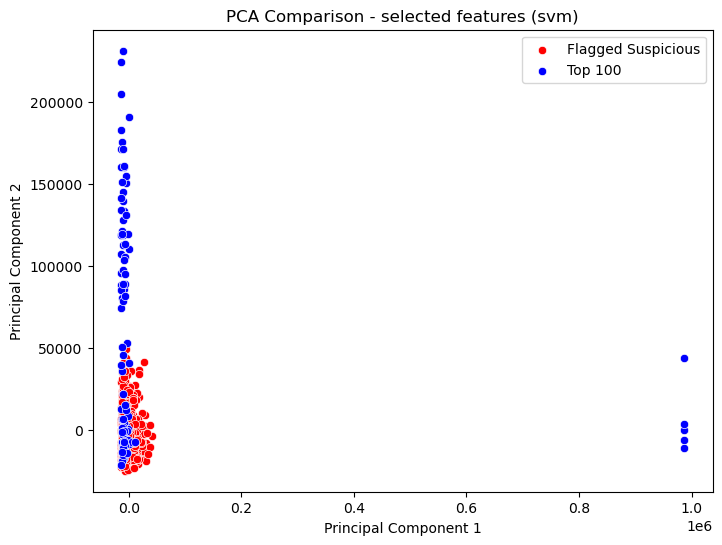

Silhouette Score for selected features (svm): 0.6656
Cluster Purity for selected features (svm): 0.9115


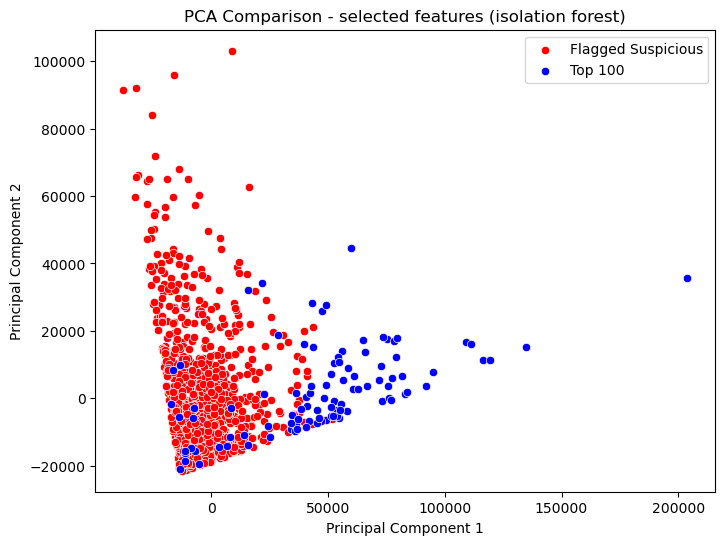

Silhouette Score for selected features (isolation forest): 0.4633
Cluster Purity for selected features (isolation forest): 0.9469


In [118]:
print('--------------------------------------------------------------------------------------------------------------------------')
print('-------------------------------- 1. Technique of feature engineering - Added new features --------------------------------')
print('--------------------------------------------------------------------------------------------------------------------------')
evaluate_model_technique(
    flagged_suspicious_clients_dataset, top_100_original_values_autoencoder, 
    numeric_columns, 'added features', 'autoencoder'
)
evaluate_model_technique(
    flagged_suspicious_clients_dataset, top_100_original_values_svm,
    numeric_columns, 'added features', 'svm'
)
evaluate_model_technique(
    flagged_suspicious_clients_dataset, top_100_original_values_forest, 
    numeric_columns, 'added features', 'isolation forest'
)

print('\n--------------------------------------------------------------------------------------------------------------------------')
print('-------------------------------- 2. Technique of feature engineering - Encoding categorical columns ----------------------')
print('--------------------------------------------------------------------------------------------------------------------------')
evaluate_model_technique(
    flagged_suspicious_clients_dataset, top_100_original_values_autoencoder_categorical, 
    numeric_columns, 'categorical features', 'autoencoder'
)
evaluate_model_technique(
    flagged_suspicious_clients_dataset, top_100_original_values_svm_categorical, 
    numeric_columns, 'categorical features', 'svm'
)
evaluate_model_technique(
    flagged_suspicious_clients_dataset, top_100_original_values_forest_categorical, 
    numeric_columns, 'categorical features', 'isolation forest'
)

print('\n--------------------------------------------------------------------------------------------------------------------------')
print('-------------------------------- 3. Technique of feature engineering - Only selected features ----------------------------')
print('--------------------------------------------------------------------------------------------------------------------------')
evaluate_model_technique(
    flagged_suspicious_clients_dataset, top_100_original_values_autoencoder_selected, 
    numeric_columns, 'selected features', 'autoencoder'
)
evaluate_model_technique(
    flagged_suspicious_clients_dataset, top_100_original_values_svm_selected, 
    numeric_columns, 'selected features', 'svm'
)
evaluate_model_technique(
    flagged_suspicious_clients_dataset, top_100_original_values_forest_selected, 
    numeric_columns, 'selected features', 'isolation forest'
)

**Best Model & Feature Engineering Technique**:
The Isolation Forest with categorical features is the best choice because:
- Its Silhouette Score (0.2374) is low, promoting overlap os suspicious and top 100 detected clients.
- Its Cluster Purity (0.7745) is still quite high, ensuring clusters align well with true labels.
- The visualization confirms the overlap.